In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from scipy.special import binom 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
from torch.autograd import Variable
import torch.utils.data as data_utils
import torch.nn.init as init
from sklearn.metrics import balanced_accuracy_score

from collections import Counter
import operator
import copy 
from itertools import product,combinations
from time import time 
#from IPython.core.display import display

%matplotlib inline

## code extracted from https://www.kaggle.com/code/graymant/breast-cancer-diagnosis-with-pytorch
## SV code extracted from https://github.com/mburaksayici/ExplainableAI-Pure-Numpy/blob/main/KernelSHAP-Pure-Numpy.ipynb

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import os
import sys
from os.path import join as osj
from bisect import bisect
from collections import defaultdict 
import pickle
import json
import wfdb


type:  local
0
full train loss:  tensor(0.0976, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0988, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  0.952020202020202
test accuracy:  0.9354420589940808
0
accuracy is best accuracy
[0.5, 1.0, 0.5]
[0.5, 1.0, 0.5]
0.9354420589940808


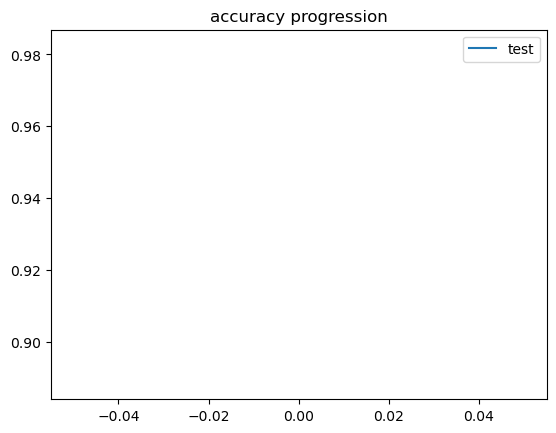

In [6]:
DATA_ROOT = osj("/mimer/NOBACKUP/groups/snic2022-22-122/arthur/", "dataset_beats")
DICT_BEATS = osj(DATA_ROOT, "5min_normal_beats.pkl")
DATA_BEATS = osj(DATA_ROOT, "30min_beats.pkl")

DATA_ROOT = "/mimer/NOBACKUP/groups/snic2022-22-122/arthur/physionet.org/files/mitdb/1.0.0/"
RECORDS = osj(DATA_ROOT, "RECORDS")
#print(RECORDS)
patient_ids = pd.read_csv(RECORDS, header=None).to_numpy().reshape(-1)
#print(patient_ids)
paced_patients = get_paced_patients(patient_ids)
excluded_patients = np.array([])#105, 114, 201, 202, 207, 209, 213, 222, 223, 234])  # according to paper
#print(np.concatenate((paced_patients, excluded_patients)))

dict_beats = read_dict_beats()
data_beats = read_data_beats()
ensure_normalized_and_detrended(dict_beats)
ensure_normalized_and_detrended(data_beats)

import collections

patients_out = np.concatenate((paced_patients, excluded_patients))
patients_left = list(copy.deepcopy(patient_ids))

for idx, i in enumerate(patient_ids):
    if i in patients_out:
        patients_left.remove(i)

labels = ['N', 'V', 'S', 'Q', 'F']
dictionary = {}
for i in labels:
    dictionary[i] = 0

list1 = []
array = np.zeros((len(patients_left), 2))
for idx, i in enumerate(patients_left):
    list1.append(data_beats[i]['class'])
    counter = collections.Counter(data_beats[i]['class'])
    for j in counter.keys():
        dictionary[j] += counter[j]
        if j == 'N':
            array[idx, 0] += counter[j]
        else:
            array[idx, 1] += counter[j]

seconds = 5
data_beats_train, data_beats_val, data_beats_test = train_test_split(data_beats, seconds)

import collections
from time import time
import random
from sklearn.metrics import f1_score, confusion_matrix
import pandas

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
experiment_name = settings['experiment_name']
test = 'local' #settings['type']
print('type: ',test)
n_epochs = 1 #settings['n_epochs']
patients_example = [205,212,232]#[200, 118, 232]
p2p = P2P_AFPL(patients_example, data_beats_train, data_beats_val,data_beats_test,2, test)
alphas = p2p.loop(n_epochs, p2p, experiment_name)

local_acc = p2p.accuracy_list
print(local_acc)
local_best = p2p.best_accuracy
print(local_best)

In [18]:

def read_dict_beats():
    with open(DICT_BEATS, "rb") as f:
        return pickle.load(f)


def read_data_beats():
    with open(DATA_BEATS, "rb") as f:
        return pickle.load(f)


def ensure_normalized_and_detrended(beats):
    for key in beats.keys():
        b = beats[key]["beats"]
        if not np.allclose(np.linalg.norm(b, axis=1, ord=2), 1):
            raise AssertionError(f"Beats of patient {key} is not normalized.")

        p = np.polyfit(np.arange(b.shape[1]), b.T, deg=1)
        if not np.allclose(p, 0):
            raise AssertionError(f"Beats of patient {key} is not detrended.")


def get_paced_patients(patient_ids):
    paced = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(osj(DATA_ROOT, str(id_)), extension='atr')
        labels = np.unique(annotation.symbol)
        if ("/" in labels):
            paced.append(id_)
    return np.array(paced)




# patient_ids = pd.read_csv(osj("..", "files", "patient_ids.csv"), header=None).to_numpy().reshape(-1)
# paced_patients = pd.read_csv(osj("..", "files", "paced_patients.csv"), header=None).to_numpy().reshape(-1)
# excluded_patients = pd.read_csv(osj("..", "files", "excluded_patients.csv"), header=None).to_numpy().reshape(-1)
def get_base_model(in_channels):
    """
    Returns the model from paper: Personalized Monitoring and Advance Warning System for Cardiac Arrhythmias.
    """
    # Input size: 128x1
    # 128x1 -> 122x32 -> 40x32 -> 34x16 -> 11x16 -> 5x16 -> 1x16
    model = nn.Sequential(
        nn.Conv1d(in_channels, 32, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),

        nn.Conv1d(32, 16, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),

        nn.Conv1d(16, 16, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),

        nn.Flatten(),

        nn.Linear(16, 32, bias=True),
        nn.ReLU(),

        nn.Linear(32, 3, bias=True),

    )
    return model


# AAMI standards: only use the first 5 seconds, only use 'healthy' heartbeats for training.
# They combine each client's dataset with other clients' datasets (with domain Adaptation)
# and test on the other 25 seconds + the abnormal heartbeats of the client.


def train_test_split(data_beats, seconds=5, data_fraction=1):
    data_beats_train = {}
    data_beats_val = {}
    data_beats_test = {}
    for i in data_beats.keys():
        data_beats_train[i] = {'class': None, 'beats': None}
        data_beats_val[i] = {'class': None, 'beats': None}
        data_beats_test[i] = {'class': None, 'beats': None}

    for patient in data_beats.keys():
        length_train = int(np.ceil(len(data_beats[patient]['beats']) * (seconds / 30)))  # only take first 5 seconds

        random_test = np.arange(int(np.ceil(len(data_beats[patient]['beats']))))
        random_val= np.arange(length_train)
        for ii in random_val:
            random_test = np.delete(random_test,ii)

        # Data fraction, take part of the data
        random_val = np.random.choice(random_val, size=int(np.ceil(data_fraction* length_train)), replace=False)

        random_train = np.random.choice(random_val, size=int(np.ceil(0.8 *data_fraction* length_train)), replace=False)
        for ii in random_train:
            index = np.where(random_val == ii)[0]
            random_val = np.delete(random_val, index)


        #random_val = np.arange(int(np.ceil(0.8 * length)))
        #random_train = np.random.choice(random_val, size=int(np.ceil(0.8 * 0.8 * length)), replace=False)
        #for ii in random_train:
        #    index = np.where(random_val == ii)[0]
        #    random_val = np.delete(random_val, index)

        data_beats_train[patient]['class'] = data_beats[patient]['class'][np.sort(random_train)]
        data_beats_test[patient]['class'] = data_beats[patient]['class'][random_test]
        data_beats_val[patient]['class'] = data_beats[patient]['class'][random_val]
        data_beats_train[patient]['beats'] = data_beats[patient]['beats'][np.sort(random_train)]
        data_beats_test[patient]['beats'] = data_beats[patient]['beats'][random_test]
        data_beats_val[patient]['beats'] = data_beats[patient]['beats'][random_val]

    return data_beats_train, data_beats_val, data_beats_test
import copy

# Combinatorial UCB
import math

# Combinatorial UCB
import math


class combinatorial_UCB(object):
    def __init__(self, n_clients, n_clients_selected=10, algorithm='UCB1_tuned'):
        self.n_clients = n_clients

        # define variables for storage
        # which clients we select
        self.times_selected = np.zeros((n_clients, n_clients))  # to record how often each client got selected
        self.reward_per_client = np.zeros((n_clients, n_clients))  # to record what reward we collected per client
        self.reward2_per_client = np.zeros(
            (n_clients, n_clients))  # to record the squared reward per client (needed for UCB1-tuned)
        # how many clients we select
        self.n_clients_selected_arr = []
        self.reward3_per_client = np.zeros((n_clients, n_clients - 1))
        self.times_selected2 = np.zeros((n_clients, n_clients - 1))

        if n_clients_selected == None:
            self.n_clients_selected = np.zeros((n_clients, 1))
        else:
            self.n_clients_selected = np.ones((n_clients, 1)) * n_clients_selected

        self.algorithm = algorithm

    def UCB(self, this_client, n):
        # for this_client in range(self.n_clients):
        other_clients = [x for x in range(self.n_clients) if x != this_client[0]]

        upper_bound = np.zeros(self.n_clients)
        for i, other_client in enumerate(other_clients):
            if self.times_selected[this_client, other_client] == 0:  # make first iteration value high
                upper_bound[other_client] = 1e500
            else:
                # We first calculate the average reward gained for this client
                average_reward = self.reward_per_client[this_client, other_client] / self.times_selected[
                    this_client, other_client]

                # Then we compute the confidence interval [avg_reward - delta, avg_reward + delta]
                if self.algorithm == 'UCB1':
                    delta = math.sqrt(2 * math.log(n) / self.times_selected[this_client, other_client])

                if self.algorithm == 'UCB1_tuned':
                    variance_bound = self.reward2_per_client[this_client, other_client] / self.times_selected[
                        this_client, other_client] - average_reward ** 2
                    variance_bound += math.sqrt(2 * math.log(n) / self.times_selected[this_client, other_client])

                    factor = np.min([variance_bound, 1 / 4])
                    delta = math.sqrt(factor * math.log(n) / self.times_selected[this_client, other_client])

                # upper bound
                upper_bound[other_client] = average_reward + delta

        if self.algorithm == 'random':
            upper_bound = np.random.rand(self.n_clients)

        # select the client with the highest upper bound
        sorted_upper_bound = np.flip(np.argsort(upper_bound))

        # if epoch == 0:
        #     n_clients_selected = self.n_clients -2

        # else:
        n_clients_selected = self.n_clients_selected[i]-1

        # Run UCB again to determine the number of clients
        # upper_bound2 = np.zeros(self.n_clients-1)
        # for ii in range(1,self.n_clients-1):
        #    if self.times_selected2[this_client,ii]==0: # make first iteration value high
        #        upper_bound2[ii] = 1e500
        #        n_clients_selected = self.n_clients -2
        #    else:
        # predict the reward when selecting these clients
        #        average_reward_n_clients = self.reward3_per_client[this_client,ii] / self.times_selected2[this_client,ii]
        #        delta = math.sqrt(2*math.log(n)) / np.sum(self.times_selected2[this_client,ii])

        #        upper_bound2[ii] = average_reward_n_clients + delta

        #        n_clients_selected = np.argmax(upper_bound2)

        # n_clients_selected_arr.append(n_clients_selected)
        selected_clients = sorted_upper_bound[:int(n_clients_selected + 1)]

        self.times_selected[this_client, selected_clients] += 1
        return selected_clients

    def collect_reward(self, this_client, selected_clients, observations):
        # collect the reward
        reward = observations[selected_clients]  # df.iloc[n,selected_client]
        self.reward_per_client[this_client, selected_clients] += reward
        self.reward2_per_client[this_client, selected_clients] += reward ** 2

        # reward for numbers of clients selected
        # n_clients_selected = len(selected_clients)-1
        # self.times_selected2[this_client,n_clients_selected] += 1

    # if epoch == 0:
    #     self.n_clients_selected[this_client] = np.sum(observations)
    # reward2 = np.abs(n_clients_selected - np.sum(observations))
    # self.reward3_per_client[this_client,n_clients_selected] += 1 - reward2 / self.n_clients

    def to_client(self, this_client, n):
        self.selected_clients = self.UCB(this_client, n)
        return self.selected_clients

    def to_server(self, this_client, observation):
        self.collect_reward(this_client, self.selected_clients, observation)





class MIT_BIH(Dataset):
    def __init__(self, patients, data):
        self.patients = patients
        self.data = data
        self.to_one_dataset()

    def to_one_dataset(self):
        data_vector = torch.zeros(self.__len__(), 128)
        labels_vector = torch.zeros(self.__len__())
        k = 0
        for i, patient in enumerate(self.patients):
            data_vector[k:k + len(self.data[patient]['beats']), :] = torch.from_numpy(self.data[patient]['beats'])
            classes = copy.deepcopy(self.data[patient]['class'])
            indices = classes == 'N'
            indices2 = classes != 'N'
            classes[indices] = 0
            classes[indices2] = 1
            classes = np.array(classes, dtype='int')
            labels_vector[k:k + len(self.data[patient]['beats'])] = torch.from_numpy(classes)
            k += len(self.data[patient]['beats'])
        self.y = labels_vector.long()
        self.X = data_vector.double()

    def __len__(self):
        length_total = 0
        for patient in self.patients:
            length_total += len(self.data[patient]['beats'])
        # print(len(self.data[patient]['beats']))
        return length_total

    def __getitem__(self, idx):
        return (self.X[idx, :], self.y[idx])
    
    
class MIT_BIH(Dataset):
    def __init__(self, patients, data):
        self.patients = patients
        self.data = data
        self.to_one_dataset()

    def to_one_dataset(self):
        length_total = 0
        for patient in self.patients:
            length_total += len(self.data[patient]['beats'])
        # print(len(self.data[patient]['beats']))
        data_vector = torch.zeros(length_total, 128)
        labels_vector = torch.zeros(length_total)
        k = 0
        for i, patient in enumerate(self.patients):
            data_vector[k:k + len(self.data[patient]['beats']), :] = torch.from_numpy(self.data[patient]['beats'])
            classes = copy.deepcopy(self.data[patient]['class'])
            indices = classes == 'N'
            indices2 = classes == 'S'
            indices3 = classes == 'V'
            indices4 = classes == 'F'
            indices5 = classes == 'Q'

            classes[indices] = 0
            classes[indices2] = 1
            classes[indices3] = 2
            classes[indices4] = 2  # classify F as V
            classes[indices5] = 3
            classes = np.array(classes, dtype='int')
            labels_vector[k:k + len(self.data[patient]['beats'])] = torch.from_numpy(classes)
            k += len(self.data[patient]['beats'])
        # remove q entries
        indices6 = np.array(labels_vector != 3)
        self.y = torch.masked_select(labels_vector, torch.from_numpy(indices6)).long()
        self.X = data_vector[indices6, :].double()

    def __len__(self):

        return len(self.y)

    def __getitem__(self, idx):
        return (self.X[idx, :], self.y[idx])


class P2P_AFPL():

    def __init__(self, patients_left, train_data, val_data,test_data, n_clients_selected,test='local'):
        self.selected_clients = patients_left
        self.network = get_base_model(1)
        self.best_test_loss = {}
        self.best_test_loss_global = 1000000
        self.current_test_loss = {}
        self.current_train_loss = {}
        self.test = test
        self.total_clients = len(self.selected_clients)
        self.patients_left = patients_left
        self.client_models = {}
        self.optimizers = {}
        self.dataloaders = {}
        self.len = {}
        self.len_test = {}
        self.len_really_test = {}
        self.dataloaders_test = {}
        self.dataloaders_really_test = {}
        if self.test == 'AFPL':
            self.client_models_global = {}

        if self.test == 'bandits':
            self.comb_UCB = combinatorial_UCB(self.total_clients,n_clients_selected)

        for idx, i in enumerate(self.patients_left):
            self.client_models[str(idx)] = copy.deepcopy(self.network).double().cuda()
            self.optimizers[str(idx)] = torch.optim.SGD(self.client_models[str(idx)].parameters(), lr=0.01,
                                                        momentum=0.5)
            dataset_train = MIT_BIH([self.patients_left[idx]], train_data)
            self.len[str(idx)] = len(dataset_train)
            self.dataloaders[str(idx)] = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=0)

            dataset_test = MIT_BIH([self.patients_left[idx]], val_data)
            self.len_test[str(idx)] = len(dataset_test)
            self.dataloaders_test[str(idx)] = DataLoader(dataset_test, batch_size=32, shuffle=False)
            self.best_test_loss[str(idx)] = 10000000
            self.current_test_loss[str(idx)] = 100000
            self.current_train_loss[str(idx)] = 1000000
            if self.test == 'AFPL':
                self.client_models_global[str(idx)] = copy.deepcopy(self.network).double().cuda()
                self.shared_model = copy.deepcopy(self.network).double().cuda()

            dataset_really_test = MIT_BIH([self.patients_left[idx]], test_data)
            self.len_really_test[str(idx)] = len(dataset_really_test)
            self.dataloaders_really_test[str(idx)] = DataLoader(dataset_really_test, batch_size=32, shuffle=False)
        self.dataset_train = dataset_train

    def update_local_models(self, selected_clients):
        self.dw = {}
        loss_test = 0
        loss_test2 = 0
        losses = 0
        losses2 = 0
        loss_test3 = 0
        losses3 = 0

        for idx, i in enumerate(selected_clients):

            dataloader = self.dataloaders[str(i)]
            optimizer = torch.optim.Adam(self.client_models[str(i)].parameters(), lr=0.001 * 0.95 ** self.iteration)
            self.client_models[str(i)].train()

            if self.test == 'AFPL':
                self.client_models_global[str(i)] = copy.deepcopy(self.shared_model)
                self.client_models_global[str(i)].train()
                optimizer_global = torch.optim.Adam(self.client_models_global[str(i)].parameters(),
                                                    lr=0.001 * 0.95 ** self.iteration)

            for batch_idx, (data, target) in enumerate(dataloader):
                #print(target)
                data = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output = F.log_softmax(output, dim=-1)
                # data = data.double().cuda()
                # target=target.long().cuda()

                optimizer.zero_grad()
                # output = self.client_models[str(i)](data)
                loss = F.nll_loss(output, target)

                if self.test == 'AFPL':
                    optimizer_global.zero_grad()
                    output_global = self.client_models_global[str(i)](data)
                    loss_global = F.nll_loss(output_global, target)
                    loss_global.backward()
                    optimizer_global.step()

                loss.backward()
                optimizer.step()

            self.client_models[str(i)].eval()
            dataloader_test = self.dataloaders_test[str(i)]
            loss_test = 0
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader_test):
                    data = data.double().unsqueeze(1).cuda()
                    target = target.long().cuda()
                    output = self.client_models[str(i)](data)
                    output = F.log_softmax(output, dim=-1)

                    loss_test += F.nll_loss(output, target)
                self.current_test_loss[str(i)] = loss_test / self.len_test[str(i)]
                if self.current_test_loss[str(i)] < self.best_test_loss[str(i)]:
                    torch.save(self.client_models[str(i)].state_dict(),
                               os.path.join(save_dir, 'model', 'best_model' + str(i) + '.pt'))
                    self.best_test_loss[str(i)] = self.current_test_loss[str(i)]

            losses += loss_test / self.len_test[str(i)]
            loss_test2 = 0
            self.client_models[str(i)].eval()
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader):
                    data = data.double().unsqueeze(1).cuda()
                    target = target.long().cuda()
                    output = self.client_models[str(i)](data)
                    output = F.log_softmax(output, dim=-1)

                    loss_test2 += F.nll_loss(output, target)

            losses2 += loss_test2 / self.len[str(i)]
            self.current_train_loss[str(i)] = loss_test2 / self.len[str(i)]

        print('full train loss: ', losses2)
        print('full loss: ', losses)

        return losses2, losses

    def combine_models(self, i, client_numbers, set_as=True):
        zero_copy = copy.deepcopy(self.client_models[str(i)])  # This is used to collect the model in
        j = 0
        client_numbers_plus_client = np.concatenate((client_numbers, np.array([int(i)])))  # This is more efficient
        #  alphas = zero_copy.alphas.detach()
        # alphas[i] = 1 - torch.sum(
        #     torch.tensor([iii for idx, iii in enumerate(alphas) if idx != i and idx in client_numbers]))
        # It's not possible to set the value of self.alphas[i], so instead we determine it manually here
        alphas = torch.ones(len(client_numbers_plus_client)).cuda() / (len(client_numbers_plus_client))
        # print(alphas)
        for ii in client_numbers_plus_client:
            #  print(ii)
            for (name, param), (name2, param2) in zip(zero_copy.named_parameters(), self.client_models[
                str(ii)].named_parameters()):  # self.client_models[str(ii)].named_parameters()):

                if name != 'alphas':
                    if j == 0:
                        param.data = torch.zeros(param.shape).cuda()

                    param.data += alphas[j] * param2.data  # we add all participating client's models to the one here.

            j += 1

        # self.client_models[str(i)] = zero_copy.double()
        if set_as == True:
            for (name, param), (name2, param2) in zip(self.client_models[str(i)].named_parameters(),
                                                      zero_copy.named_parameters()):
                param.data = param2.data
            self.client_models[str(i)].double()
        else:
            return zero_copy.double()

    def federated_averaging(self):
        self.shared_model = copy.deepcopy(self.network).double().cuda()
        n_clients = len(self.selected_clients)
        weight = [self.len[str(x)] for x in self.selected_clients]
        weight = weight / np.sum(weight)

        losses = 0
        losses2 = 0
        # print("weights ",weight)
        for idx, i in enumerate(self.selected_clients):
            for (name, param), (name2, param2) in zip(self.shared_model.named_parameters()
                    , self.client_models[str(i)].named_parameters()):
                if idx == 0:
                    param.data = torch.zeros(param.shape).cuda().double()
                param.data += weight[idx] * param2.data

        self.shared_model = self.shared_model.double().eval()

        for i in self.selected_clients:
            self.client_models[str(i)] = copy.deepcopy(self.shared_model)  # copy global model to the clients
            loss_test = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders_test[str(i)]):
                data = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.shared_model(data)
                output = F.log_softmax(output, dim=-1)

                loss_test += F.nll_loss(output, target).detach().cpu().numpy()

            loss_test = loss_test / self.len_test[str(i)]
            losses += loss_test
            if loss_test < self.best_test_loss[str(i)]:
                torch.save(self.client_models[str(i)].state_dict(),
                           os.path.join(save_dir, 'model', 'best_model' + str(i) + '.pt'))
                self.best_test_loss[str(i)] = loss_test
            self.client_models[str(i)].eval()
            loss_test2 = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders[str(i)]):
                data = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.shared_model(data)
                output = F.log_softmax(output, dim=-1)

                loss_test2 += F.nll_loss(output, target).detach().cpu().numpy()

            loss_test2 = loss_test2 / self.len[str(i)]
            losses2 += loss_test2

        return losses, losses2

    def AFPL(self):  # use alpha = 0.25 = 0.75 global model + 0.25 local model
        self.shared_model_old = copy.deepcopy(self.shared_model)
        self.shared_model = copy.deepcopy(self.network).double().cuda()
        n_clients = len(self.selected_clients)
        weight = [self.len[str(x)] for x in self.selected_clients]
        weight = weight / np.sum(weight)

        losses = 0
        losses2 = 0

        # accumulate local weights
        for idx, i in enumerate(self.selected_clients):
            for (name, param), (name2, param2), (name3, param3), (name4, param4) in zip(
                    self.shared_model.named_parameters()
                    , self.client_models_global[str(i)].named_parameters(),
                    self.shared_model_old.named_parameters(),
                    self.client_models[str(i)].named_parameters()):
                if idx == 0:
                    param.data = torch.zeros(param.shape).cuda().double()
                param.data += weight[idx] * param2.data  # accumulate local weights
                param4.data = 0.25 * param4.data + 0.75 * param3.data  # do AFPL local model update: note that we take the previous global model
            self.client_models[str(i)] = self.client_models[str(i)].double()
            self.client_models[str(i)].eval()
            loss_test = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders_test[str(i)]):
                data = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output = F.log_softmax(output, dim=-1)

                loss_test += F.nll_loss(output, target).detach().cpu().numpy()

            loss_test = loss_test / self.len_test[str(i)]
            losses += loss_test
            if loss_test < self.best_test_loss[str(i)]:
                torch.save(self.client_models[str(i)].state_dict(),
                           os.path.join(save_dir, 'model', 'best_model' + str(i) + '.pt'))
                self.best_test_loss[str(i)] = loss_test
            self.client_models[str(i)].eval()
            loss_test2 = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders[str(i)]):
                data = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output = F.log_softmax(output, dim=-1)

                loss_test2 += F.nll_loss(output, target).detach().cpu().numpy()

            loss_test2 = loss_test2 / self.len[str(i)]
            losses2 += loss_test2

        self.shared_model = self.shared_model.double()
        return losses, losses2
    
    def calc_accuracy(self, dataloaders, length):
        accuracies = np.zeros(len(self.selected_clients))
        total = 0
        self.accuracy_list = []
        preds = []
        trues = []
        for i in self.selected_clients:
            # dataloader = self.dataloaders_really_test[str(i)]
            dataloader = dataloaders[str(i)]
            intermediate_accuracy = 0
            self.client_models[str(i)].eval()
            y_pred = []
            y_true = []
            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output = F.log_softmax(output, dim=-1)
                output_array = output.detach().cpu().numpy()
                output_class = np.argmax(output_array, axis=-1)
                target_array = target.detach().cpu().numpy()
                intermediate_accuracy += np.sum(output_class == target_array)
                y_pred.append(list(output_class))
                y_true.append(list(target_array))

            # accuracy = intermediate_accuracy / p2p.len_really_test[str(i)] * 100
            # print(i)
            accuracy = intermediate_accuracy / length[str(i)] * 100

            #self.accuracy_list.append(accuracy)
            for sub in y_pred:
                for j in sub:
                    preds.append(j)
            for sub in y_true:
                for j in sub:
                    trues.append(j)
            #preds.append([j for sub in y_pred for j in sub])
            pred = np.array([j for sub in y_pred for j in sub])
            true = np.array([j for sub in y_true for j in sub])
            #print(i)

            #print(pred)
            #print(true)
            #print(balanced_accuracy_score(true, pred))
            self.accuracy_list.append(balanced_accuracy_score(true,pred))

            C = confusion_matrix(true, pred).ravel()
            if len(C) == 4:
                df = pandas.DataFrame([[C[3], C[1]], [C[2], C[0]]], columns=['Positive', 'Negative'],
                                      index=['Predicted Positive', 'Predicted Negative'])

            total += length[str(i)]
            accuracies[i] = intermediate_accuracy

        overall_accuracy = np.sum(accuracies) / total * 100
        #print()

       # breakpoint()
    # just for debugging 
        self.trues = trues 
        self.preds = preds 
        print(np.unique(trues,return_counts=True))
        print(np.unique(preds,return_counts=True))

        return balanced_accuracy_score(trues,preds)#overall_accuracy

    
    def calc_accuracy2(self, dataloaders, length):
        accuracies = np.zeros(len(self.selected_clients))
        total = 0
        self.accuracy_list = []
        for i in self.selected_clients:
            # dataloader = self.dataloaders_really_test[str(i)]
            dataloader = dataloaders[str(i)]
            intermediate_accuracy = 0
            self.client_models[str(i)].eval()
            y_pred = []
            y_true = []
            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output = F.log_softmax(output, dim=-1)
                
                output_array = output.detach().cpu().numpy()
                output_class = np.argmax(output_array, axis=-1)
                target_array = target.detach().cpu().numpy()
                intermediate_accuracy += np.sum(output_class == target_array)
                y_pred.append(list(output_class))
                y_true.append(list(target_array))

            # accuracy = intermediate_accuracy / p2p.len_really_test[str(i)] * 100
            # print(i)
            accuracy = intermediate_accuracy / length[str(i)] * 100
            #if self.iteration % 5 == 0:
            #    print('client accuracy : ', str(i))
             #   print(accuracy)
            self.accuracy_list.append(accuracy)

            pred = np.array([j for sub in y_pred for j in sub])
            true = np.array([j for sub in y_true for j in sub])
            C = confusion_matrix(true, pred).ravel()
            if len(C) == 4:
                df = pandas.DataFrame([[C[3], C[1]], [C[2], C[0]]], columns=['Positive', 'Negative'],
                                      index=['Predicted Positive', 'Predicted Negative'])

            total += length[str(i)]
            accuracies[i] = intermediate_accuracy
        overall_accuracy = np.sum(accuracies) / total * 100

        return overall_accuracy

    def my_method2(self, client, k=30):

        selected_clients = []
        other_clients = [x for x in range(self.total_clients) if x is not client]
        ey = np.zeros(len(other_clients))  # fix indices
        current_test = np.zeros(len(other_clients))
        collected_clients = []
        list1 = np.arange(len(other_clients))
        np.random.shuffle(list1)
        for i in list1[:k]:
            shared_model = self.combine_models(client, [other_clients[i]], set_as=False)

            if len(collected_clients) > 0:
                all_clients = collected_clients + [other_clients[i]]
                shared_model2 = self.combine_models(client, all_clients, set_as=False)

            shared_model.eval().cuda()
            self.client_models[str(client)].eval().cuda()
            loss_test = 0
            loss_test2 = 0
            loss_test3 = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders_test[str(client)]):
                data = data.unsqueeze(1).double().cuda()
                target = target.long().cuda()
                output = shared_model(data)
                output = F.log_softmax(output, dim=-1)
                local_output = self.client_models[str(client)](data)
                local_output = F.log_softmax(local_output, dim=-1)

                loss_test += F.nll_loss(output, target).detach().cpu().numpy()
                loss_test2 += F.nll_loss(local_output, target).detach().cpu().numpy()

                if len(collected_clients) > 0:
                    output2 = shared_model2(data)
                    output2 = F.log_softmax(output2, dim=-1)
                    loss_test3 += F.nll_loss(output2, target).detach().cpu().numpy()

            ey[i] = loss_test / self.len_test[str(client)]
            current_test[i] = loss_test2 / self.len_test[str(client)]
            if ey[i] < current_test[i]:
                if len(collected_clients) > 0:
                    test2 = loss_test3 / self.len_test[str(client)]
                    if test2 < current_test[i]:
                        collected_clients.append(other_clients[i])
                else:
                    collected_clients.append(other_clients[i])
        loss_test = current_test[i]
        # print(client)
        # print(loss_test)
        # print(self.current_test_loss[str(client)])
        # print(ey)

        selected_clients = np.where(ey <= self.current_test_loss[str(client)].detach().cpu().numpy())[0]
        selected_clients = [other_clients[x] for x in selected_clients]
        # print(selected_clients)
        selected_clients = collected_clients

        if len(selected_clients) > 0:
            self.combine_models(client, selected_clients, set_as=True)
            loss_test = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders_test[str(client)]):
                data = data.unsqueeze(1).double().cuda()
                target = target.long().cuda()
                output = self.client_models[str(client)](data)
                output = F.log_softmax(output, dim=-1)

                loss_test += F.nll_loss(output, target).detach().cpu().numpy()

            loss_test = loss_test / self.len_test[str(client)]
            if loss_test < self.best_test_loss[str(client)]:
                torch.save(self.client_models[str(client)].state_dict(),
                           os.path.join(save_dir, 'model', 'best_model' + str(i) + '.pt'))
                self.best_test_loss[str(client)] = loss_test
            self.client_models[str(client)].eval()
            loss_test2 = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders[str(client)]):
                data = data.unsqueeze(1).double().cuda()
                target = target.long().cuda()
                output = self.client_models[str(client)](data)
                output = F.log_softmax(output, dim=-1)
                loss_test2 += F.nll_loss(output, target).detach().cpu().numpy()

            loss_test2 = loss_test2 / self.len[str(client)]
        return loss_test, loss_test2, selected_clients

    def bandits(self, client, n):

        selected_clients = []
        other_clients = [x for x in range(self.total_clients) if x != client]
        # print(other_clients)
        ey = np.zeros(self.total_clients)  # fix indices
        current_test = np.zeros(self.total_clients)
        collected_clients = []

        selected_clients_UCB = self.comb_UCB.to_client([client], n)
        if client == 1:
            print('selected clients UCB: ', selected_clients_UCB)
        for i in selected_clients_UCB:
            shared_model = self.combine_models(client, [i], set_as=False)

            if len(collected_clients) > 0:
                all_clients = collected_clients + [i]
                shared_model2 = self.combine_models(client, all_clients, set_as=False)

            shared_model.eval().cuda()
            self.client_models[str(client)].eval().cuda()
            loss_test = 0
            loss_test2 = 0
            loss_test3 = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders_test[str(client)]):
                data = data.unsqueeze(1).double().cuda()
                target = target.long().cuda()
                output = shared_model(data)
                output = F.log_softmax(output, dim=-1)
                output2 = self.client_models[str(client)](data)
                output2 = F.log_softmax(output2, dim=-1)
                loss_test += F.nll_loss(output, target).detach().cpu().numpy()
                loss_test2 += F.nll_loss(output2, target).detach().cpu().numpy()

                if len(collected_clients) > 0:
                    output = shared_model2(data)
                    output = F.log_softmax(output, dim=-1)
                    loss_test3 += F.nll_loss(output, target).detach().cpu().numpy()

            ey[i] = loss_test / self.len_test[str(client)]
            current_test[i] = loss_test2 / self.len_test[str(client)]
            if ey[i] < current_test[i]:
                if len(collected_clients) > 0:
                    test2 = loss_test3 / self.len_test[str(client)]
                    if test2 < current_test[i]:
                        collected_clients.append(i)
                else:
                    collected_clients.append(i)
        loss_test = current_test[i]
        selected_clients = np.where(ey <= self.current_test_loss[str(client)].detach().cpu().numpy())[0]
        # selected_clients = [other_clients[x] for x in selected_clients]

        selected_clients = collected_clients

        observation = np.zeros(self.total_clients)
        observation[selected_clients] = 1
        if client == 1:
            print(observation)

        self.comb_UCB.to_server(client, observation)

        if len(selected_clients) > 0:
            self.combine_models(client, selected_clients, set_as=True)
            loss_test = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders_test[str(client)]):
                data = data.unsqueeze(1).double().cuda()
                target = target.long().cuda()
                output2 = self.client_models[str(client)](data)
                output2 = F.log_softmax(output2, dim=-1)

                loss_test += F.nll_loss(output2, target).detach().cpu().numpy()

            loss_test = loss_test / self.len_test[str(client)]
            if loss_test < self.best_test_loss[str(client)]:
                torch.save(self.client_models[str(client)].state_dict(),
                           os.path.join(save_dir, 'model', 'best_model' + str(i) + '.pt'))
                self.best_test_loss[str(client)] = loss_test
            self.client_models[str(client)].eval()
            loss_test2 = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders[str(client)]):
                data = data.unsqueeze(1).double().cuda()
                target = target.long().cuda()
                output2 = self.client_models[str(client)](data)
                output2 = F.log_softmax(output2, dim=-1)

                loss_test2 += F.nll_loss(output2, target).detach().cpu().numpy()

            loss_test2 = loss_test2 / self.len[str(client)]
            
        return loss_test, loss_test2, selected_clients, selected_clients_UCB

    def loop(self, epochs, p2p, experiment_name):

        loss_tests = []
        loss_trains = []
        loss_tests2 = []
        loss_trains2 = []
        accuracies = []
        accuracies_train = []
        self.p2p = p2p
        self.phis = np.zeros((self.total_clients, self.total_clients))
        self.phisUCB = np.zeros((self.total_clients, self.total_clients))
        self.selected_clients_arr = np.zeros((epochs, self.total_clients, self.total_clients))
        best_accuracy = 0

        for i in range(epochs):
            print(i)
            self.iteration = i
            list1 = []
            self.selected_clients = [x for x in range(self.total_clients)]

            loss_train, loss_test = self.update_local_models(self.selected_clients)
            loss_tests.append(loss_test.detach().cpu().numpy())
            loss_trains.append(loss_train.detach().cpu().numpy())

            if self.test == 'AFPL':
                losses2, losses3 = self.AFPL()

            if self.test == 'local':
                print('we are done')

            if self.test == 'federated':
                losses2, losses3 = self.federated_averaging()

            if self.test == 'bandits':
                losses2 = 0
                losses3 = 0
                for client in range(self.total_clients):
                    loss_test2, loss_train2, selected_clients2,selected_clients_UCB = self.bandits(client, i)
                    losses2 += loss_test2
                    if len(selected_clients2) < 1:
                        losses3 += self.current_train_loss[str(client)].detach().cpu().numpy()
                    else:
                        losses3 += loss_train2
                    self.phis[client, selected_clients2] += 1
                    self.phisUCB[client,selected_clients_UCB] += 1
                    self.selected_clients_arr[i, client, selected_clients2] += 1
                fname = os.path.join('checkpoints_bandits', experiment_name, 'phi' + str(i) + '.txt')
                np.savetxt(fname, self.phis)
                fname = os.path.join('checkpoints_bandits', experiment_name, 'phi_UCB' + str(i) + '.txt')
                np.savetxt(fname, self.phisUCB)

            if self.test == 'mine':
                losses2 = 0
                losses3 = 0
                for client in range(self.total_clients):
                    loss_test2, loss_train2, selected_clients2 = self.my_method2(client)
                    losses2 += loss_test2
                    if len(selected_clients2) < 1:
                        losses3 += self.current_train_loss[str(client)].detach().cpu().numpy()

                    else:
                        losses3 += loss_train2
                    self.phis[client, selected_clients2] += 1
                    # print(selected_clients2)
                fname = os.path.join('checkpoints_bandits', experiment_name, 'phi' + str(i) + '.txt')
                np.savetxt(fname, self.phis)

            if self.test == 'optimal':
                losses2, losses3 = self.optimal_fedavg()
                losses2 = losses2.detach().cpu().numpy()
                losses3 = losses3.detach().cpu().numpy()

            if self.test != 'local':
                print('loss after my code: ', losses2)
                print('train loss after my code: ', losses3)
                loss_tests2.append(losses2)
                loss_trains2.append(losses3)
                fname = os.path.join('checkpoints_bandits', experiment_name, 'losses_test.txt')
                np.savetxt(fname, loss_tests2)
                fname = os.path.join('checkpoints_bandits', experiment_name, 'losses_train.txt')
                np.savetxt(fname, loss_trains2)


            else:
                fname = os.path.join('checkpoints_bandits', experiment_name, 'losses_test.txt')
                np.savetxt(fname, loss_tests)
                fname = os.path.join('checkpoints_bandits', experiment_name, 'losses_train.txt')
                np.savetxt(fname, loss_trains)

            accuracy_val = self.calc_accuracy(self.dataloaders_test, self.len_test)
            print('val accuracy: ', accuracy_val)

            accuracy = self.calc_accuracy(self.dataloaders_really_test, self.len_really_test)
            print('test accuracy: ', accuracy)
            accuracies.append(accuracy)
            if accuracy_val > best_accuracy:
                print(best_accuracy)
                print('accuracy is best accuracy')
                print(self.accuracy_list)
                best_accuracy = accuracy_val
                self.best_accuracy = accuracy

                # save all of this in a .txt file
                fname = os.path.join('checkpoints_bandits', experiment_name, 'test_accuracies.txt')
                np.savetxt(fname, self.accuracy_list)
                fname = os.path.join('checkpoints_bandits', experiment_name, 'test_accuracy.txt')
                np.savetxt(fname, [accuracy])
            # accuracy_train = self.calc_accuracy(test=False)
            # print(accuracy_train)
            # accuracies_train.append(accuracy_train)
        # print(self.phis)
        fname = os.path.join('checkpoints_bandits', experiment_name, 'accuracies.txt')
        np.savetxt(fname, accuracies)

        plt.figure()
        plt.plot(loss_trains, label='train loss before')
        plt.plot(loss_tests, label='test loss before')
        plt.plot(loss_trains2, label='train loss after')
        plt.plot(loss_tests2, label='test loss after')
        plt.title('loss curve')
        plt.legend(loc="upper right")
        plt.savefig(os.path.join('checkpoints_bandits', experiment_name, 'loss_curve.png'))
        plt.clf()
        plt.plot(accuracies, label='test')
        # plt.plot(accuracies_train,label='train')
        plt.title('accuracy progression')
        plt.legend()
        plt.savefig(os.path.join('checkpoints_bandits', experiment_name, 'accuracy_progression.png'))

import yaml
import os
import shutil
def init():
    with open('settings/train_settings_bandits.yaml', 'r') as file:
        settings = yaml.safe_load(file)
    if not os.path.isdir('checkpoints_bandits'):
        os.mkdir('checkpoints_bandits')
    if not os.path.isdir(os.path.join('checkpoints_bandits', settings['experiment_name'])):
        os.mkdir(os.path.join('checkpoints_bandits', settings['experiment_name']))
    save_dir = os.path.join('checkpoints_bandits', settings['experiment_name'])
    if not os.path.isdir(os.path.join(save_dir, 'model')):
        os.mkdir(os.path.join(save_dir, 'model'))
    shutil.copyfile('settings/train_settings.yaml', save_dir + '/train_settings.yaml')
    return settings,save_dir



settings, save_dir = init()

In [13]:
local_acc = p2p.accuracy_list
print(local_acc)
local_best = p2p.best_accuracy
print(local_best)

[0.5, 1.0, 0.5]
0.9354420589940808


checkpoints_bandits/MIT3B_bandits_010_20_5
type:  bandits
0
full train loss:  tensor(0.0993, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1092, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.10916934946328163
train loss after my code:  0.0992658288852627
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
0
accuracy is best accuracy
[0.3333333333333333, 0.3333333333333333, 0.5]
1
full train loss:  tensor(0.0857, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0942, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[1. 0. 0.]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


loss after my code:  0.09304928429279295
train loss after my code:  0.08473169607676784
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
2
full train loss:  tensor(0.0744, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0817, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[1. 0. 0.]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


loss after my code:  0.0811608191243994
train loss after my code:  0.07397291995938038
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
3
full train loss:  tensor(0.0670, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0727, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.07274869325282003
train loss after my code:  0.06699073196432614


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
4
full train loss:  tensor(0.0610, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0667, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.06669542765308259
train loss after my code:  0.06096400669322717


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
5
full train loss:  tensor(0.0574, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0628, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.06275019594739666
train loss after my code:  0.05738348088750596


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
6
full train loss:  tensor(0.0550, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0594, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.059399681592193936
train loss after my code:  0.055036218100968884


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
7
full train loss:  tensor(0.0529, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0568, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.05679710932937756
train loss after my code:  0.052868190752489


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
8
full train loss:  tensor(0.0509, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0544, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.054401793702163456
train loss after my code:  0.050910973685631314
(array([0, 1, 2]), array([140,  47,  34]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
9
full train loss:  tensor(0.0491, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0526, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.05262820125542901
train loss after my code:  0.0490986972992091
(array([0, 1, 2]), array([140,  47,  34]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
10
full train loss:  tensor(0.0466, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0501, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.05008620143659135
train loss after my code:  0.046615419776773234


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
11
full train loss:  tensor(0.0446, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0474, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.047393806380618284
train loss after my code:  0.044628582503301775
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
12
full train loss:  tensor(0.0421, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0447, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.04472767702077404
train loss after my code:  0.04214285065451804
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([161,  59,   1]))
val accuracy:  0.6289528577388402


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3947, 1481,  114]))
test accuracy:  0.6612918850027537
0.6191489361702128
accuracy is best accuracy
[0.3870056497175141, 0.3333333333333333, 0.5]
13
full train loss:  tensor(0.0400, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0425, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.042502378924339536
train loss after my code:  0.039996132324143466


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([140,  59,  22]))
val accuracy:  0.8348352106800166
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3572, 1481,  489]))
test accuracy:  0.8346622040041406
0.6289528577388402
accuracy is best accuracy
[0.5635593220338984, 0.3333333333333333, 0.5]
14
full train loss:  tensor(0.0381, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0401, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.04012075858081926
train loss after my code:  0.03811319308236151


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([137,  59,  25]))
val accuracy:  0.8642469753858991
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3503, 1481,  558]))
test accuracy:  0.8665623427003958
0.8348352106800166
accuracy is best accuracy
[0.596045197740113, 0.3333333333333333, 0.5]
15
full train loss:  tensor(0.0355, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0384, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.03839124687317928
train loss after my code:  0.03546928990277162


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([137,  59,  25]))
val accuracy:  0.8642469753858991
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3497, 1481,  564]))
test accuracy:  0.869336267804418
16
full train loss:  tensor(0.0337, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0365, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.03649978068958143
train loss after my code:  0.03369220374098818
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([137,  59,  25]))
val accuracy:  0.8642469753858991


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3472, 1481,  589]))
test accuracy:  0.8808942890711772
17
full train loss:  tensor(0.0322, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0345, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.03453643726282556
train loss after my code:  0.03223896009120239
(array([0, 1, 2]), array([140,  47,  34]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([137,  59,  25]))
val accuracy:  0.8642469753858991
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3461, 1481,  600]))
test accuracy:  0.8859798184285511
18
full train loss:  tensor(0.0296, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0333, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.03327225547703537
train loss after my code:  0.02964090110631852


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([137,  59,  25]))
val accuracy:  0.8642469753858991
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3458, 1481,  603]))
test accuracy:  0.8873667809805622
19
full train loss:  tensor(0.0278, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0315, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.03151319134310507
train loss after my code:  0.02779013996124264
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([135,  59,  27]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.883854818523154
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3448, 1481,  613]))
test accuracy:  0.8919899894872659
0.8642469753858991
accuracy is best accuracy
[0.621939736346516, 0.3333333333333333, 0.5]
20
full train loss:  tensor(0.0261, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0299, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.02988326396177452
train loss after my code:  0.026086851668974814


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([139,  55,  27]))
val accuracy:  0.8933786280469634
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3548, 1376,  618]))
test accuracy:  0.9036734959863227
0.883854818523154
accuracy is best accuracy
[0.6238229755178908, 0.3333333333333333, 0.662037037037037]
21
full train loss:  tensor(0.0246, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0285, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.028515799927501757
train loss after my code:  0.024630509661728923


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([139,  55,  27]))
val accuracy:  0.8933786280469634
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3552, 1371,  619]))
test accuracy:  0.9040481330566609
22
full train loss:  tensor(0.0238, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0271, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.027126714525426213
train loss after my code:  0.023806437097734594
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  51,  27]))
val accuracy:  0.902902437570773


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1320,  626]))
test accuracy:  0.9115986808074941
0.8933786280469634
accuracy is best accuracy
[0.6264148969350973, 0.3333333333333333, 0.7484567901234568]
23
full train loss:  tensor(0.0220, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0258, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.02575473324898885
train loss after my code:  0.021996291919546704


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  51,  27]))
val accuracy:  0.902902437570773
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3597, 1313,  632]))
test accuracy:  0.9131789373819265
24
full train loss:  tensor(0.0215, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0246, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.024619406120143374
train loss after my code:  0.02153757024880988
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([145,  49,  27]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.9076643423326778
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3652, 1252,  638]))
test accuracy:  0.9216660778086049
0.902902437570773
accuracy is best accuracy
[0.6301813752778469, 0.3333333333333333, 0.8533950617283951]
25
full train loss:  tensor(0.0203, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0236, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[1. 0. 0.]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


loss after my code:  0.023508515105630266
train loss after my code:  0.021675862924713678
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([144,  48,  29]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3658, 1239,  645]))
test accuracy:  0.9246392724223006
0.9076643423326778
accuracy is best accuracy
[0.631831677109366, 0.3333333333333333, 0.8734567901234568]
26
full train loss:  tensor(0.0207, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0226, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[1. 0. 0.]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


loss after my code:  0.022607000371029078
train loss after my code:  0.020928993418185715
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([145,  47,  29]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3681, 1213,  648]))
test accuracy:  0.9284613759315095
0.929653137850885
accuracy is best accuracy
[0.6332441064878971, 0.3333333333333333, 0.9135802469135803]
27
full train loss:  tensor(0.0203, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0217, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.021668719974949555
train loss after my code:  0.020256379846656503


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([146,  46,  29]))
val accuracy:  0.9344150426127898
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3686, 1207,  649]))
test accuracy:  0.929485652387687
0.9320340902318375
accuracy is best accuracy
[0.6337149162807408, 0.3333333333333333, 0.9228395061728395]
28
full train loss:  tensor(0.0194, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0206, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.020550169022611024
train loss after my code:  0.019396339988063494


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([146,  46,  29]))
val accuracy:  0.9344150426127898
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3681, 1204,  657]))
test accuracy:  0.9320782344437925
29
full train loss:  tensor(0.0172, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0197, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.01967214726306728
train loss after my code:  0.017167257233468746


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([145,  46,  30]))
val accuracy:  0.9344150426127898
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3680, 1202,  660]))
test accuracy:  0.9331901946803022
30
full train loss:  tensor(0.0165, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0189, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.018899535341438407
train loss after my code:  0.016471476592249738
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([145,  46,  30]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.9344150426127898
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3680, 1200,  662]))
test accuracy:  0.9334820437895766
31
full train loss:  tensor(0.0154, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0184, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.018366139372612694
train loss after my code:  0.015372948948877196
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([145,  46,  30]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.9344150426127898
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3681, 1197,  664]))
test accuracy:  0.9337738928988509
32
full train loss:  tensor(0.0150, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0177, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.01771108145036094
train loss after my code:  0.014980362036135973


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  46,  32]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3677, 1194,  671]))
test accuracy:  0.935160855450862
33
full train loss:  tensor(0.0135, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0172, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.01715767514447738
train loss after my code:  0.013537474543544712
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  46,  32]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3651, 1194,  697]))
test accuracy:  0.9363545239804519
34
full train loss:  tensor(0.0130, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0169, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.01689810569206175
train loss after my code:  0.01301417787029845
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  46,  32]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3653, 1194,  695]))
test accuracy:  0.9345988998453549
35
full train loss:  tensor(0.0124, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0164, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.01642741678749072
train loss after my code:  0.012407591723610216
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3631, 1191,  720]))
test accuracy:  0.9358153906559701
36
full train loss:  tensor(0.0122, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0161, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.01607103304105214
train loss after my code:  0.012182574274042183


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3612, 1193,  737]))
test accuracy:  0.9373728249493771
37
full train loss:  tensor(0.0119, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0157, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.015694175583352385
train loss after my code:  0.011871224472322767


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3601, 1185,  756]))
test accuracy:  0.9387934810889345
38
full train loss:  tensor(0.0108, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0155, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.015487095089383982
train loss after my code:  0.010830284677645432
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3607, 1183,  752]))
test accuracy:  0.9372360467955275
39
full train loss:  tensor(0.0101, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0152, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.015184704389057245
train loss after my code:  0.01009095528686952
(array([0, 1, 2]), array([140,  47,  34]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3603, 1183,  756]))
test accuracy:  0.9376983676461977
40
full train loss:  tensor(0.0099, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0147, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.01474261322579449
train loss after my code:  0.009912654788388537
(array([0, 1, 2]), array([140,  47,  34]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3599, 1180,  763]))
test accuracy:  0.9388103278827077
41
full train loss:  tensor(0.0094, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0144, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.014366035488567698
train loss after my code:  0.009388565171972044


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3600, 1175,  767]))
test accuracy:  0.9393831547947356
42
full train loss:  tensor(0.0094, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0141, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.014083690929174268
train loss after my code:  0.009425367817477853


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1178,  769]))
test accuracy:  0.9403846089698877
43
full train loss:  tensor(0.0093, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0137, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.013741908043866302
train loss after my code:  0.009318472849195897


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1174,  773]))
test accuracy:  0.9417884183156721
44
full train loss:  tensor(0.0085, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0135, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.013525453765686613
train loss after my code:  0.008514405597057653


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3594, 1173,  775]))
test accuracy:  0.9418820775832565
45
full train loss:  tensor(0.0086, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0133, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.013337975974824248
train loss after my code:  0.008645748200879934


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1171,  776]))
test accuracy:  0.9417116058418605
46
full train loss:  tensor(0.0082, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0132, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.013213719656769204
train loss after my code:  0.008155122361281485
(array([0, 1, 2]), array([140,  47,  34]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1171,  775]))
test accuracy:  0.9412492849911902
47
full train loss:  tensor(0.0078, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0130, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.012980977698862656
train loss after my code:  0.007798426019195813
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3597, 1170,  775]))
test accuracy:  0.9413429442587747
48
full train loss:  tensor(0.0077, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0128, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.012835610181746114
train loss after my code:  0.007701345276732743
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3593, 1170,  779]))
test accuracy:  0.9418052651094451
49
full train loss:  tensor(0.0076, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0127, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.012656130499791186
train loss after my code:  0.007569629136311241


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3592, 1169,  781]))
test accuracy:  0.9428235660783703
50
full train loss:  tensor(0.0073, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0126, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.012590176317496145
train loss after my code:  0.007258787949185701
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1169,  778]))
test accuracy:  0.9414366035263594
51
full train loss:  tensor(0.0075, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0125, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.012477188478895231
train loss after my code:  0.007467110706079591


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3593, 1170,  779]))
test accuracy:  0.9422675859601154
52
full train loss:  tensor(0.0071, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0123, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.012253869736145166
train loss after my code:  0.007098226780414986


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3592, 1169,  781]))
test accuracy:  0.9428235660783703
53
full train loss:  tensor(0.0076, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0122, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.012154490856070198
train loss after my code:  0.0075998723773386834


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3591, 1168,  783]))
test accuracy:  0.9432858869290408
54
full train loss:  tensor(0.0069, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0121, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.012051881599550222
train loss after my code:  0.006883773052373698


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3593, 1166,  783]))
test accuracy:  0.9431154151876449
55
full train loss:  tensor(0.0067, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0119, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.011933831769115551
train loss after my code:  0.0066862581405168035


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3591, 1168,  783]))
test accuracy:  0.9432858869290408
56
full train loss:  tensor(0.0068, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0118, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.011824913498546252
train loss after my code:  0.00679228222067731


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3593, 1166,  783]))
test accuracy:  0.9431154151876449
57
full train loss:  tensor(0.0066, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0117, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.011698384300958552
train loss after my code:  0.006615315182854841


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3592, 1167,  783]))
test accuracy:  0.9430217559200603
58
full train loss:  tensor(0.0065, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0116, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.011639120769125023
train loss after my code:  0.0065206799810505044
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3591, 1168,  783]))
test accuracy:  0.9432858869290408
59
full train loss:  tensor(0.0066, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0116, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.011575193342492887
train loss after my code:  0.006550058265354242


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3593, 1166,  783]))
test accuracy:  0.9431154151876449
60
full train loss:  tensor(0.0066, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0115, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.01145014830674939
train loss after my code:  0.006589952755763549
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1164,  783]))
test accuracy:  0.9433027337228138
61
full train loss:  tensor(0.0065, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0114, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.011421644607906095
train loss after my code:  0.006529067390911416
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1163,  783]))
test accuracy:  0.9433963929903983
62
full train loss:  tensor(0.0060, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0113, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.011310388748726698
train loss after my code:  0.005992300966569824


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1163,  783]))
test accuracy:  0.9433963929903983
63
full train loss:  tensor(0.0061, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0113, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.011268937921575677
train loss after my code:  0.006077514376247293
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1163,  783]))
test accuracy:  0.9433963929903983
64
full train loss:  tensor(0.0059, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0112, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.011213067283818904
train loss after my code:  0.005858859623462003


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1163,  783]))
test accuracy:  0.9433963929903983
65
full train loss:  tensor(0.0059, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0112, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.01115306589416608
train loss after my code:  0.005910955815251546


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1163,  783]))
test accuracy:  0.9433963929903983
66
full train loss:  tensor(0.0060, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0111, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.011106349183598093
train loss after my code:  0.006006447440698798


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1163,  783]))
test accuracy:  0.9433963929903983
67
full train loss:  tensor(0.0061, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0111, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.011064617014748897
train loss after my code:  0.006055596375863644


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1163,  783]))
test accuracy:  0.9433963929903983
68
full train loss:  tensor(0.0057, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0110, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.011021388324935762
train loss after my code:  0.0056725678272659535


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1163,  783]))
test accuracy:  0.9433963929903983
69
full train loss:  tensor(0.0061, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0110, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.01099828939351069
train loss after my code:  0.006127558152615783


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1163,  783]))
test accuracy:  0.9433963929903983
70
full train loss:  tensor(0.0055, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0110, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010951350453824444
train loss after my code:  0.005521038487731451


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1163,  784]))
test accuracy:  0.9438587138410687
71
full train loss:  tensor(0.0056, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0109, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010898685497447554
train loss after my code:  0.0056290996609863475


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1163,  784]))
test accuracy:  0.9438587138410687
72
full train loss:  tensor(0.0055, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0108, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.010829764034616472
train loss after my code:  0.005475487430125911


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1161,  785]))
test accuracy:  0.9441505629503432
73
full train loss:  tensor(0.0055, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0108, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.01080262064661885
train loss after my code:  0.005463076125795907


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.929653137850885
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1161,  785]))
test accuracy:  0.9441505629503432
74
full train loss:  tensor(0.0055, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0108, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.010780609819620993
train loss after my code:  0.005541936830629035
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1161,  785]))
test accuracy:  0.9441505629503432
75
full train loss:  tensor(0.0057, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0108, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010767090653866938
train loss after my code:  0.005710798015774374


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1161,  785]))
test accuracy:  0.9441505629503432
76
full train loss:  tensor(0.0053, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0107, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010730231430438657
train loss after my code:  0.005338988011107073
(array([0, 1, 2]), array([140,  47,  34]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1161,  785]))
test accuracy:  0.9441505629503432
77
full train loss:  tensor(0.0054, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0107, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.01071788302677629
train loss after my code:  0.005397663759419738
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1161,  785]))
test accuracy:  0.9441505629503432
78
full train loss:  tensor(0.0054, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0107, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010680231191668475
train loss after my code:  0.005431657618735807


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1161,  785]))
test accuracy:  0.9441505629503432
79
full train loss:  tensor(0.0054, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0107, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010664324785863186
train loss after my code:  0.005401501895506603


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([143,  45,  33]))
val accuracy:  0.9320340902318375
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1161,  785]))
test accuracy:  0.9441505629503432
80
full train loss:  tensor(0.0052, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0106, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.01063032572158755
train loss after my code:  0.005246514415233522


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
0.9344150426127898
accuracy is best accuracy
[0.6436117921567234, 0.5880806185684234, 0.9760489025470299]
81
full train loss:  tensor(0.0054, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0106, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010598785756712949
train loss after my code:  0.005406978430575771


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
82
full train loss:  tensor(0.0055, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0106, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.010570853792920686
train loss after my code:  0.005536163530095536


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
83
full train loss:  tensor(0.0052, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0106, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010569011097337152
train loss after my code:  0.005162950678302141
(array([0, 1, 2]), array([140,  47,  34]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
84
full train loss:  tensor(0.0052, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0106, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010561704881540155
train loss after my code:  0.0052314707659325554


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
85
full train loss:  tensor(0.0054, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0105, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.01054832622539939
train loss after my code:  0.00543523607773193


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
86
full train loss:  tensor(0.0053, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0105, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010524859820292984
train loss after my code:  0.00528397300584129


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
87
full train loss:  tensor(0.0054, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0105, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.010502124405857688
train loss after my code:  0.00540482889130084


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
88
full train loss:  tensor(0.0055, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0105, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010488298483247447
train loss after my code:  0.005462633840351541


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
89
full train loss:  tensor(0.0051, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0105, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.0104779428234755
train loss after my code:  0.005074787555372865
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val accuracy:  0.9394570594195125
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
90
full train loss:  tensor(0.0051, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0105, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.010481975586049574
train loss after my code:  0.0051011660240878965
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
91
full train loss:  tensor(0.0052, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0105, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.01047133205819037
train loss after my code:  0.005195333083961676
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3596, 1160,  786]))
test accuracy:  0.9447065430685981
92
full train loss:  tensor(0.0051, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0105, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010458393346824987
train loss after my code:  0.005053510397308831


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.9418380118004649
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
0.9394570594195125
accuracy is best accuracy
[0.6436117921567234, 0.5880806185684234, 0.9760489025470299]
93
full train loss:  tensor(0.0052, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0104, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.010439816351939458
train loss after my code:  0.005248774374377612


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.9418380118004649
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
94
full train loss:  tensor(0.0052, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0104, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010428017222434086
train loss after my code:  0.00515585439175496


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.9418380118004649
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
95
full train loss:  tensor(0.0052, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0104, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.01041055831740997
train loss after my code:  0.005171004338157266


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
96
full train loss:  tensor(0.0051, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0104, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010409946519071843
train loss after my code:  0.005058428926884167
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.9418380118004649


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
97
full train loss:  tensor(0.0050, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0104, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010405852720877051
train loss after my code:  0.005029068943211917
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([141,  45,  35]))
val accuracy:  0.9394570594195125


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
98
full train loss:  tensor(0.0050, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0104, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [2]
[0. 0. 0.]
loss after my code:  0.010396719620926309
train loss after my code:  0.005027002961103294
(array([0, 1, 2]), array([140,  47,  34]))


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.9418380118004649
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136
99
full train loss:  tensor(0.0050, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0104, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [0]
[0. 0. 0.]
loss after my code:  0.010389832434341604
train loss after my code:  0.0049732598592699


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([142,  45,  34]))
val accuracy:  0.9418380118004649
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3595, 1161,  786]))
test accuracy:  0.9446128838010136


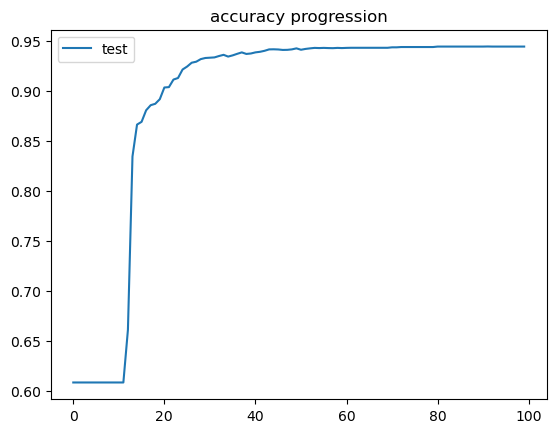

In [21]:
print(save_dir)
DATA_ROOT = osj("/mimer/NOBACKUP/groups/snic2022-22-122/arthur/", "dataset_beats")
DICT_BEATS = osj(DATA_ROOT, "5min_normal_beats.pkl")
DATA_BEATS = osj(DATA_ROOT, "30min_beats.pkl")

DATA_ROOT = "/mimer/NOBACKUP/groups/snic2022-22-122/arthur/physionet.org/files/mitdb/1.0.0/"
RECORDS = osj(DATA_ROOT, "RECORDS")
#print(RECORDS)
patient_ids = pd.read_csv(RECORDS, header=None).to_numpy().reshape(-1)
#print(patient_ids)
paced_patients = get_paced_patients(patient_ids)
excluded_patients = np.array([105, 114, 201, 202, 207, 209, 213, 222, 223, 234])  # according to paper
#print(np.concatenate((paced_patients, excluded_patients)))

dict_beats = read_dict_beats()
data_beats = read_data_beats()
ensure_normalized_and_detrended(dict_beats)
ensure_normalized_and_detrended(data_beats)

import collections

patients_out = np.concatenate((paced_patients, excluded_patients))
patients_left = list(copy.deepcopy(patient_ids))

for idx, i in enumerate(patient_ids):
    if i in patients_out:
        patients_left.remove(i)

labels = ['N', 'V', 'S', 'Q', 'F']
dictionary = {}
for i in labels:
    dictionary[i] = 0

list1 = []
array = np.zeros((len(patients_left), 2))
for idx, i in enumerate(patients_left):
    list1.append(data_beats[i]['class'])
    counter = collections.Counter(data_beats[i]['class'])
    for j in counter.keys():
        dictionary[j] += counter[j]
        if j == 'N':
            array[idx, 0] += counter[j]
        else:
            array[idx, 1] += counter[j]

seconds = 5
data_beats_train, data_beats_val, data_beats_test = train_test_split(data_beats, seconds)

import collections
from time import time
import random
from sklearn.metrics import f1_score, confusion_matrix
import pandas

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
experiment_name = settings['experiment_name']
test = 'bandits'
print('type: ',test)
n_epochs = 100 #settings['n_epochs']
patients_example = [200, 118,232]
p2p = P2P_AFPL(patients_example, data_beats_train, data_beats_val,data_beats_test,1,test)
alphas = p2p.loop(n_epochs, p2p, experiment_name)


In [22]:
bandit_acc = p2p.accuracy_list
print(bandit_acc)
bandit_best = p2p.best_accuracy
print(bandit_best)

[0.6436117921567234, 0.5880806185684234, 0.9760489025470299]
0.9446128838010136


type:  local
0
full train loss:  tensor(0.0993, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1092, device='cuda:0', dtype=torch.float64)
we are done
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
0
accuracy is best accuracy
[0.3333333333333333, 0.3333333333333333, 0.5]
1
full train loss:  tensor(0.0856, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0944, device='cuda:0', dtype=torch.float64)
we are done
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1]), array([162,  59]))
val accuracy:  0.6191489361702128
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1]), array([4061, 1481]))
test accuracy:  0.6085873080263321
2
full train loss:  tensor(0.0752, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0829, device='cuda:0', dtype=torch.float64)
we are done
(ar

(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3446, 1481,  615]))
test accuracy:  0.8929146311886066
21
full train loss:  tensor(0.0262, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0296, device='cuda:0', dtype=torch.float64)
we are done
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([135,  59,  27]))
val accuracy:  0.883854818523154
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3443, 1481,  618]))
test accuracy:  0.8943015937406177
22
full train loss:  tensor(0.0245, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0283, device='cuda:0', dtype=torch.float64)
we are done
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([139,  55,  27]))
val accuracy:  0.8933786280469634
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3530, 1387,  625]))
test accuracy:  0.9053235098793307
0.883854818523154
accuracy is best accuracy
[0.6264148969350973, 0.33333333333

(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3673, 1198,  671]))
test accuracy:  0.9378302499807788
40
full train loss:  tensor(0.0135, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0163, device='cuda:0', dtype=torch.float64)
we are done
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([145,  46,  30]))
val accuracy:  0.9344150426127898
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3675, 1194,  673]))
test accuracy:  0.937500177804508
41
full train loss:  tensor(0.0133, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0160, device='cuda:0', dtype=torch.float64)
we are done
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([145,  46,  30]))
val accuracy:  0.9344150426127898
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3675, 1194,  673]))
test accuracy:  0.937500177804508
42
full train loss:  tensor(0.0131, device='cuda:0', dtype=torch.float64)
full 

(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3680, 1178,  684]))
test accuracy:  0.9403029006768078
61
full train loss:  tensor(0.0117, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0128, device='cuda:0', dtype=torch.float64)
we are done
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([146,  45,  30]))
val accuracy:  0.9367959949937422
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3683, 1175,  684]))
test accuracy:  0.9405838784795614
62
full train loss:  tensor(0.0111, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0128, device='cuda:0', dtype=torch.float64)
we are done
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([146,  45,  30]))
val accuracy:  0.9367959949937422
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3686, 1175,  681]))
test accuracy:  0.9406775377471459
63
full train loss:  tensor(0.0108, device='cuda:0', dtype=torch.float64)
ful

(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3693, 1170,  679]))
test accuracy:  0.9396101424047032
82
full train loss:  tensor(0.0101, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0121, device='cuda:0', dtype=torch.float64)
we are done
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([146,  45,  30]))
val accuracy:  0.9367959949937422
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3693, 1170,  679]))
test accuracy:  0.9396101424047032
83
full train loss:  tensor(0.0101, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0121, device='cuda:0', dtype=torch.float64)
we are done
(array([0, 1, 2]), array([140,  47,  34]))
(array([0, 1, 2]), array([146,  45,  30]))
val accuracy:  0.9367959949937422
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0, 1, 2]), array([3693, 1170,  679]))
test accuracy:  0.9396101424047032
84
full train loss:  tensor(0.0101, device='cuda:0', dtype=torch.float64)
ful

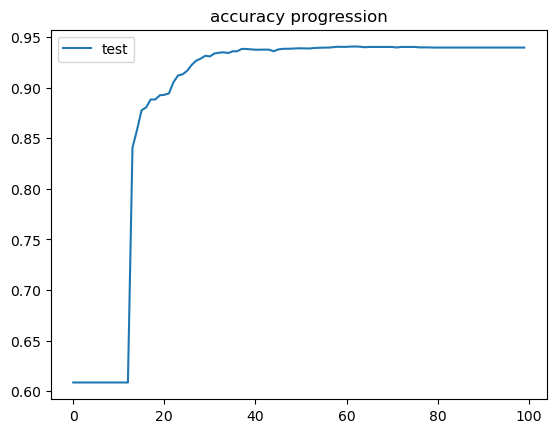

In [25]:
seconds = 5
data_beats_train, data_beats_val, data_beats_test = train_test_split(data_beats, seconds)

import collections
from time import time
import random
from sklearn.metrics import f1_score, confusion_matrix
import pandas

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
experiment_name = settings['experiment_name']
test = 'local'
print('type: ',test)
n_epochs = 100 #settings['n_epochs']
patients_example = [200, 118,232]
p2p = P2P_AFPL(patients_example, data_beats_train, data_beats_val,data_beats_test,1,test)
alphas = p2p.loop(n_epochs, p2p, experiment_name)

In [15]:
print(np.unique(p2p.trues,return_counts=True))
print(np.count_nonzero(p2p.trues==0))
print(p2p.trues[:10])
print(np.unique(p2p.preds,return_counts=True))

(array([0, 1]), array([3559, 1983]))
0
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
(array([0, 1]), array([4061, 1481]))


In [26]:
local_acc = p2p.accuracy_list
print(local_acc)
local_best = p2p.best_accuracy
print(local_best)

[0.6431360472507471, 0.3333333333333333, 0.9641353756522296]
0.9383371357255164


checkpoints_bandits/MIT3B_bandits_010_20_5
type:  federated
0
full train loss:  tensor(0.0993, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1092, device='cuda:0', dtype=torch.float64)
loss after my code:  0.11609631931580047
train loss after my code:  0.10531331355315579
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
0
accuracy is best accuracy
[0.3333333333333333, 0.3333333333333333, 0.5]
1
full train loss:  tensor(0.0898, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0987, device='cuda:0', dtype=torch.float64)
loss after my code:  0.11061497331674765
train loss after my code:  0.10003225959487061
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.33333

(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
19
full train loss:  tensor(0.0994, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1108, device='cuda:0', dtype=torch.float64)
loss after my code:  0.11990674355062807
train loss after my code:  0.10603843826539357
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
20
full train loss:  tensor(0.1006, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1118, device='cuda:0', dtype=torch.float64)
loss after my code:  0.12035160116058383
train loss after my code:  0.10550129269479112
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
21
full tra

(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
38
full train loss:  tensor(0.1038, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1162, device='cuda:0', dtype=torch.float64)
loss after my code:  0.12062270190440394
train loss after my code:  0.10715463568547817
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
39
full train loss:  tensor(0.1037, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1162, device='cuda:0', dtype=torch.float64)
loss after my code:  0.12039798692879564
train loss after my code:  0.10690167884953408
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
40
full tra

(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
57
full train loss:  tensor(0.1023, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1143, device='cuda:0', dtype=torch.float64)
loss after my code:  0.11637977947148881
train loss after my code:  0.10302790329485444
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
58
full train loss:  tensor(0.1021, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1142, device='cuda:0', dtype=torch.float64)
loss after my code:  0.11616347603201753
train loss after my code:  0.10348719147169666
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
59
full tra

(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
76
full train loss:  tensor(0.0994, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1129, device='cuda:0', dtype=torch.float64)
loss after my code:  0.113772731757303
train loss after my code:  0.10129653066004146
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
77
full train loss:  tensor(0.1011, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1129, device='cuda:0', dtype=torch.float64)
loss after my code:  0.11369724432681308
train loss after my code:  0.10012681787607652
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
78
full train

(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
95
full train loss:  tensor(0.1016, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1129, device='cuda:0', dtype=torch.float64)
loss after my code:  0.1131756629783606
train loss after my code:  0.10128122252081606
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
96
full train loss:  tensor(0.0980, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1129, device='cuda:0', dtype=torch.float64)
loss after my code:  0.11315479204766818
train loss after my code:  0.10056561938985133
(array([0, 1, 2]), array([140,  47,  34]))
(array([0]), array([221]))
val accuracy:  0.3333333333333333
(array([0, 1, 2]), array([3559, 1262,  721]))
(array([0]), array([5542]))
test accuracy:  0.3333333333333333
97
full trai

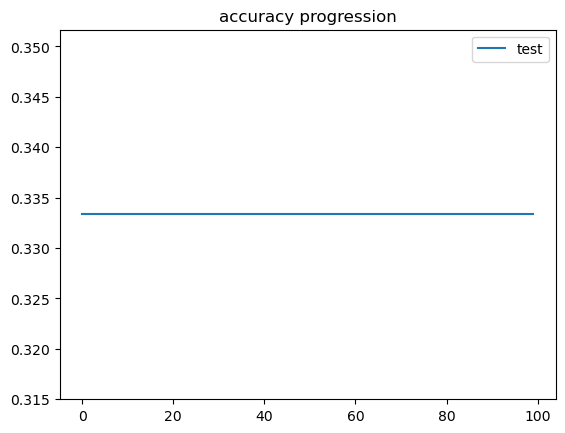

In [27]:
print(save_dir)
DATA_ROOT = osj("/mimer/NOBACKUP/groups/snic2022-22-122/arthur/", "dataset_beats")
DICT_BEATS = osj(DATA_ROOT, "5min_normal_beats.pkl")
DATA_BEATS = osj(DATA_ROOT, "30min_beats.pkl")

DATA_ROOT = "/mimer/NOBACKUP/groups/snic2022-22-122/arthur/physionet.org/files/mitdb/1.0.0/"
RECORDS = osj(DATA_ROOT, "RECORDS")
#print(RECORDS)
patient_ids = pd.read_csv(RECORDS, header=None).to_numpy().reshape(-1)
#print(patient_ids)
paced_patients = get_paced_patients(patient_ids)
excluded_patients = np.array([105, 114, 201, 202, 207, 209, 213, 222, 223, 234])  # according to paper
#print(np.concatenate((paced_patients, excluded_patients)))

dict_beats = read_dict_beats()
data_beats = read_data_beats()
ensure_normalized_and_detrended(dict_beats)
ensure_normalized_and_detrended(data_beats)

import collections

patients_out = np.concatenate((paced_patients, excluded_patients))
patients_left = list(copy.deepcopy(patient_ids))

for idx, i in enumerate(patient_ids):
    if i in patients_out:
        patients_left.remove(i)

labels = ['N', 'V', 'S', 'Q', 'F']
dictionary = {}
for i in labels:
    dictionary[i] = 0

list1 = []
array = np.zeros((len(patients_left), 2))
for idx, i in enumerate(patients_left):
    list1.append(data_beats[i]['class'])
    counter = collections.Counter(data_beats[i]['class'])
    for j in counter.keys():
        dictionary[j] += counter[j]
        if j == 'N':
            array[idx, 0] += counter[j]
        else:
            array[idx, 1] += counter[j]

seconds = 5
data_beats_train, data_beats_val, data_beats_test = train_test_split(data_beats, seconds)

import collections
from time import time
import random
from sklearn.metrics import f1_score, confusion_matrix
import pandas

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
experiment_name = settings['experiment_name']
test = 'federated'
print('type: ',test)
n_epochs = 100 #settings['n_epochs']
patients_example = [200, 118, 232]
p2p = P2P_AFPL(patients_example, data_beats_train, data_beats_val,data_beats_test,1,test)
alphas = p2p.loop(n_epochs, p2p, experiment_name)

In [28]:
federated_acc = p2p.accuracy_list
print(federated_acc)
federated_best = p2p.best_accuracy
print(federated_best)

[0.3333333333333333, 0.3333333333333333, 0.5]
0.3333333333333333


### Centralized training

In [29]:
from sklearn.metrics import f1_score, confusion_matrix
import pandas 
# Global model 
patients_train = [200,118, 232]
best_accuracy = 0 
mit_bih = MIT_BIH(patients_train,data_beats_test)
dataloader_test = DataLoader(mit_bih,batch_size=32,shuffle=False,num_workers=0)
mit_bih = MIT_BIH(patients_train,data_beats_val)
dataloader_val = DataLoader(mit_bih,batch_size=32,shuffle=False,num_workers=0)


mit_bih = MIT_BIH(patients_train,data_beats_train)
dataloader = DataLoader(mit_bih,batch_size=32,shuffle=True,num_workers=0)
model = get_base_model(1)
model.double().train()
#crit = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters())
for i in range(100):
    print(i)
    losses = 0 
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.double().unsqueeze(1)
        target=target.long()

        optimizer.zero_grad()
        output = model(data)
        output = F.log_softmax(output,dim=-1)
        loss = F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        losses += loss.detach().cpu().numpy()

# calculate accuracy on test set 
    with torch.no_grad():
        model.double().eval()

        losses = 0 
        len_total = 0 
        accuracy = 0 
        y_true = []
        y_pred = []
        for batch_idx, (data, target) in enumerate(dataloader_val):
            data = data.double().unsqueeze(1)
            target=target.long()
            output = model(data)
            output = F.log_softmax(output,dim=-1)
            loss = F.nll_loss(output,target)
            losses += loss.detach().cpu().numpy()

            output1 = np.argmax(output.detach().cpu().numpy(),axis=1)
            target1 = target.detach().cpu().numpy()
            accuracy += sum(output1 == target1)
            len_total += len(target)
            y_pred.append(list(output1))
            y_true.append(list(target1))
       # val_accuracy = accuracy/len_total*100
        pred = np.array([j for sub in y_pred for j in sub])
        true = np.array([j for sub in y_true for j in sub])
        val_accuracy = balanced_accuracy_score(true,pred)
        print('validation')
        print(val_accuracy)
        
    if val_accuracy > best_accuracy: 
        best_accuracy = val_accuracy 
        with torch.no_grad():
            model.double().eval()

            losses = 0 
            len_total = 0 
            accuracy = 0 
            y_true = []
            y_pred = []
            for batch_idx, (data, target) in enumerate(dataloader_test):
                data = data.double().unsqueeze(1)
                target=target.long()
                output = model(data)
                output = F.log_softmax(output,dim=-1)
                loss = F.nll_loss(output,target)
                losses += loss.detach().cpu().numpy()

                output1 = np.argmax(output.detach().cpu().numpy(),axis=1)
                target1 = target.detach().cpu().numpy()
                accuracy += sum(output1 == target1)
                len_total += len(target)
                y_pred.append(list(output1))
                y_true.append(list(target1))
            pred = np.array([j for sub in y_pred for j in sub])
            true = np.array([j for sub in y_true for j in sub])
            test_accuracy = balanced_accuracy_score(true,pred) #accuracy/len_total*100
            print('test')
            print(test_accuracy)

            # per-patient accuracy 
            for patient in patients_train: 
                mit_bih = MIT_BIH([patient],data_beats_test)
                dataloader_testc = DataLoader(mit_bih,batch_size=32,shuffle=False,num_workers=0)
                with torch.no_grad():
                    model.double().eval()

                    losses = 0 
                    len_total = 0 
                    accuracy = 0 
                    y_true = []
                    y_pred = []
                    for batch_idx, (data, target) in enumerate(dataloader_testc):
                        data = data.double().unsqueeze(1)
                        target=target.long()
                        output = model(data)
                        output = F.log_softmax(output,dim=-1)
                        loss = F.nll_loss(output,target)
                        losses += loss.detach().cpu().numpy()

                        output1 = np.argmax(output.detach().cpu().numpy(),axis=1)
                        target1 = target.detach().cpu().numpy()
                        accuracy += sum(output1 == target1)
                        len_total += len(target)
                        y_pred.append(list(output1))
                        y_true.append(list(target1))
                    test_accuracy = accuracy/len_total*100
                    pred = np.array([j for sub in y_pred for j in sub])
                    true = np.array([j for sub in y_true for j in sub])
                    test_accuracy = balanced_accuracy_score(true,pred)
                    print(patient)
                    print(test_accuracy)


        



0
validation
0.3333333333333333
test
0.3333333333333333
200
0.3333333333333333
118
0.3333333333333333
232
0.5
1
validation
0.3333333333333333
2
validation
0.3333333333333333
3
validation
0.3333333333333333
4
validation
0.3333333333333333
5
validation
0.3333333333333333
6
validation
0.9046218487394958
test
0.9176017027328176
200
0.7477306831320263
118
0.5881304555278004


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


232
0.9734546560389257
7
validation
0.9242296918767506
test
0.9342715060979717
200
0.7837245891024806
118
0.6470174109105878
232
0.9777761772143795
8


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


validation
0.9465492580010727
test
0.9415561491951463
200
0.7351291374849631
118
0.6741864701111382
232
0.9738868081564711
9


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


validation
0.9462184873949581
10
validation
0.9391262888133977
11
validation
0.9489302103820251
test
0.9465045340588524
200
0.7766386018171542
118
0.7975230491439197


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


232
0.9726517067341037
12
validation
0.9658263305322129
test
0.9553243082613291
200
0.8284062682314467
118
0.817880997257348
232
0.9775294236904724
13


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


validation
0.9756302521008404
test
0.9513616104469858
200
0.8374603027092101
118
0.817880997257348
232
0.9766651194553817
14


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


validation
0.9830532212885155
test
0.9590832070865486
200
0.8326534265933051
118
0.8433372483233552
232
0.9753686631027455
15


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


validation
0.9759610227069552
16
validation
0.988145896656535
test
0.959074148127648
200
0.7967640690964432
118
0.887104353915098


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


232
0.9754300180330143
17
validation
0.9854341736694678
18
validation
0.9904761904761905
test
0.9643609507983603
200
0.8627745479360446
118
0.8859957064649872
232
0.9733933011086568
19


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


validation
0.988145896656535
20
validation
0.9854341736694678
21
validation
0.9854341736694678
22
validation
0.9952380952380953
test
0.9603839318660294
200
0.8485119950582055
118
0.8614633282740725


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


232
0.9762943222681051
23
validation
0.9854341736694678
24
validation
0.9854341736694678
25
validation
0.9854341736694678
26
validation
0.9854341736694678
27
validation
0.9854341736694678
28
validation
0.9830532212885155
29
validation
0.9854341736694678
30
validation
0.9830532212885155
31
validation
0.9830532212885155
32
validation
0.9854341736694678
33
validation
0.9830532212885155
34
validation
0.9854341736694678
35
validation
0.9830532212885155
36
validation
0.9830532212885155
37
validation
0.9830532212885155
38
validation
0.9830532212885155
39
validation
0.9830532212885155
40
validation
0.9830532212885155
41
validation
0.9830532212885155
42
validation
0.9854341736694678
43
validation
0.9854341736694678
44
validation
0.9854341736694678
45
validation
0.9854341736694678
46
validation
0.9854341736694678
47
validation
0.9854341736694678
48
validation
0.9854341736694678
49
validation
0.9854341736694678
50
validation
0.9854341736694678
51
validation
0.9854341736694678
52
validation
0.9854

# all patients

checkpoints_bandits/test
type:  local
0
full train loss:  tensor(0.7566, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.8835, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  58.56747130985358
test accuracy:  58.415420258790526
0
accuracy is best accuracy
[98.36152219873149, 0.3221649484536082, 0.11527377521613834, 29.045643153526974, 1.2951601908657124, 98.43453510436433, 0.056561085972850686, 99.90539262062441, 0.2008032128514056, 0.24615384615384617, 95.26892430278885, 0.07830853563038372, 95.14767932489451, 21.825876662636034, 0.12903225806451613, 100.0, 0.23752969121140144, 4.305864884929473, 66.09699769053118, 85.24788391777508, 96.6078697421981, 53.82113821138211, 91.34179510426111, 100.0, 88.90069038767923, 95.10714285714286, 52.20301171221416, 48.328445747800586, 84.15841584158416, 16.910473961380927, 99.94675186368477, 0.07651109410864575, 78.12288993923025, 72.50390015600624]
1
full train loss:  tensor(0.5077, device='cuda:0', dtype=torch.float64)

full train loss:  tensor(0.1291, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1582, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  96.51760981400871
test accuracy:  95.86281895695755
96.3197467352592
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 70.95435684647303, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 95.26892430278885, 99.92169146436962, 95.14767932489451, 99.75816203143893, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 96.44341801385681, 85.24788391777508, 96.6078697421981, 97.76422764227642, 91.34179510426111, 100.0, 88.90069038767923, 95.10714285714286, 96.65365309537088, 95.19061583577712, 98.06930693069307, 83.08952603861908, 99.94675186368477, 99.92348890589136, 89.66914247130318, 98.08892355694228]
13
full train loss:  tensor(0.1218, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1476, device='cuda:0', dtype=torch.float

full train loss:  tensor(0.0722, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0986, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.02136921250495
test accuracy:  97.75252565052247
24
full train loss:  tensor(0.0707, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0962, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.02136921250495
test accuracy:  97.78247096092925
25
full train loss:  tensor(0.0675, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0948, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.06094182825484
test accuracy:  97.81084020236726
26
full train loss:  tensor(0.0671, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0929, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.17965967550455
test accuracy:  97.9227410991505
98.06094182825484
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 92.5311203319502, 98.7048398091

full train loss:  tensor(0.0481, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0764, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.41709537000396
test accuracy:  98.42708316915947
42
full train loss:  tensor(0.0477, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0757, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.41709537000396
test accuracy:  98.46333275544139
43
full train loss:  tensor(0.0462, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0749, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.45666798575385
test accuracy:  98.47909344512917
98.41709537000396
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 97.0954356846473, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 96.46414342629483, 99.92169146436962, 95.14767932489451, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 95.694135

test accuracy:  98.64458068685086
64
full train loss:  tensor(0.0407, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0683, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.53581321725366
test accuracy:  98.64300461788208
65
full train loss:  tensor(0.0397, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0681, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.53581321725366
test accuracy:  98.65088496272597
66
full train loss:  tensor(0.0401, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0679, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.57538583300357
test accuracy:  98.65403710066353
67
full train loss:  tensor(0.0394, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0678, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.53581321725366
test accuracy:  98.6556131696323
68
full train loss:  tensor(0.0398, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.

full train loss:  tensor(0.0384, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0658, device='cuda:0', dtype=torch.float64)
we are done
val accuracy:  98.61495844875347
test accuracy:  98.67767813519521


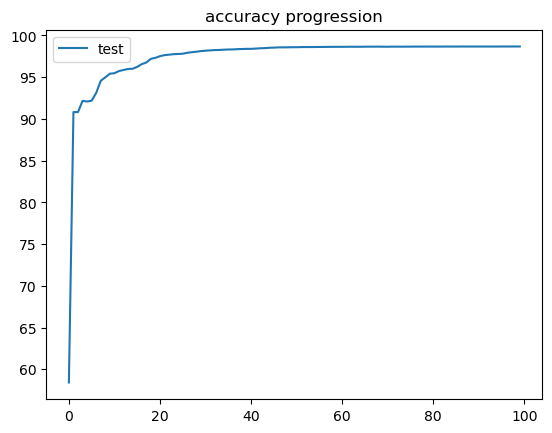

In [16]:
print(save_dir)
DATA_ROOT = osj("/mimer/NOBACKUP/groups/snic2022-22-122/arthur/", "dataset_beats")
DICT_BEATS = osj(DATA_ROOT, "5min_normal_beats.pkl")
DATA_BEATS = osj(DATA_ROOT, "30min_beats.pkl")

DATA_ROOT = "/mimer/NOBACKUP/groups/snic2022-22-122/arthur/physionet.org/files/mitdb/1.0.0/"
RECORDS = osj(DATA_ROOT, "RECORDS")
#print(RECORDS)
patient_ids = pd.read_csv(RECORDS, header=None).to_numpy().reshape(-1)
#print(patient_ids)
paced_patients = get_paced_patients(patient_ids)
excluded_patients = np.array([105, 114, 201, 202, 207, 209, 213, 222, 223, 234])  # according to paper
#print(np.concatenate((paced_patients, excluded_patients)))

dict_beats = read_dict_beats()
data_beats = read_data_beats()
ensure_normalized_and_detrended(dict_beats)
ensure_normalized_and_detrended(data_beats)

import collections

patients_out = np.concatenate((paced_patients, excluded_patients))
patients_left = list(copy.deepcopy(patient_ids))

for idx, i in enumerate(patient_ids):
    if i in patients_out:
        patients_left.remove(i)

labels = ['N', 'V', 'S', 'Q', 'F']
dictionary = {}
for i in labels:
    dictionary[i] = 0

list1 = []
array = np.zeros((len(patients_left), 2))
for idx, i in enumerate(patients_left):
    list1.append(data_beats[i]['class'])
    counter = collections.Counter(data_beats[i]['class'])
    for j in counter.keys():
        dictionary[j] += counter[j]
        if j == 'N':
            array[idx, 0] += counter[j]
        else:
            array[idx, 1] += counter[j]

seconds = 5
data_beats_train, data_beats_val, data_beats_test = train_test_split(data_beats, seconds)

import collections
from time import time
import random
from sklearn.metrics import f1_score, confusion_matrix
import pandas

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
experiment_name = settings['experiment_name']
test = settings['type']
print('type: ',test)
n_epochs = 100 #settings['n_epochs']
#patients_example = [119, 215, 232]
p2p = P2P_AFPL(patients_left, data_beats_train, data_beats_val,data_beats_test,settings['n_clients_UCB'], test)
alphas = p2p.loop(n_epochs, p2p, experiment_name)

[98.36152219873149, 99.6778350515464, 99.88472622478386, 97.9253112033195, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.55179282868527, 99.92169146436962, 95.25316455696202, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 97.78290993071593, 96.49334945586457, 96.6078697421981, 98.3739837398374, 97.1894832275612, 100.0, 99.62825278810409, 99.92857142857143, 96.65365309537088, 95.19061583577712, 99.20792079207921, 98.36161497952018, 99.94675186368477, 99.92348890589136, 98.37947332883186, 99.57098283931357]


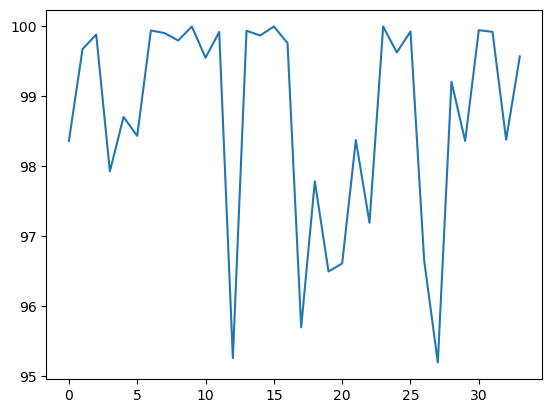

In [21]:
best_accuracies_local = p2p.accuracy_list
print(best_accuracies_local)
plt.plot(best_accuracies_local)

In [26]:
print(patients_left)
print(patients_left[12])
print(best_accuracies_local[12])
print(patients_left[17])
print(best_accuracies_local[17])
print(patients_left[27])
print(best_accuracies_local[27])

[100, 101, 103, 106, 108, 109, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 203, 205, 208, 210, 212, 214, 215, 219, 220, 221, 228, 230, 231, 232, 233]
118
95.25316455696202
124
95.69413511507052
220
95.19061583577712


checkpoints_bandits/test
type:  bandits
0
full train loss:  tensor(0.7566, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.8835, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [33 32  2  3  4  5  6  7  8  9]
[0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
loss after my code:  0.8386080380543226
train loss after my code:  0.7200478886191799
val accuracy:  91.49188761377127
test accuracy:  90.81467004996139
0
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 70.95435684647303, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 95.26892430278885, 99.92169146436962, 95.14767932489451, 78.17412333736397, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 66.09699769053118, 85.24788391777508, 96.6078697421981, 53.82113821138211, 91.34179510426111, 100.0, 88.90069038767923, 95.10714285714286, 96.65365309537088, 95.1906

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
loss after my code:  0.5002620124288578
train loss after my code:  0.440274848947099
val accuracy:  91.49188761377127
test accuracy:  90.81467004996139
2
full train loss:  tensor(0.3321, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.3731, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [ 0 26 19 20 22 24 25 23 27 28]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
loss after my code:  0.33515887437834085
train loss after my code:  0.3101404531661879
val accuracy:  91.88761377127028
test accuracy:  90.9360273605573
91.49188761377127
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 70.95435684647303, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 95.26892430278885, 99.92169146436962, 95.14767932489451, 78.17412333736397, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 66.09699769053118, 85.24788391777508, 96.6078697421981, 56.95121951219512, 91.34179510426111, 100.0, 88.90069038767923, 95.10714285714286, 96.65365309537088, 95.19061583577712, 84.15841584158416, 83.08952603861908, 99.94675186368477, 99.92348890589136, 78.12288993923025, 72.50390015600624]
3
full train loss:  tensor(0.2631, device='cuda:0', dtype=torch.float64)
full loss:  tensor

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
loss after my code:  0.28253742903831336
train loss after my code:  0.2712860633887907
val accuracy:  92.5207756232687
test accuracy:  91.77764818988479
91.88761377127028
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 70.95435684647303, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 95.26892430278885, 99.92169146436962, 95.14767932489451, 78.17412333736397, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 66.09699769053118, 85.24788391777508, 96.6078697421981, 78.65853658536585, 91.34179510426111, 100.0, 88.90069038767923, 95.10714285714286, 96.65365309537088, 95.19061583577712, 84.15841584158416, 83.08952603861908, 99.94675186368477, 99.92348890589136, 78.12288993923025, 72.50390015600624]
4
full train loss:  tensor(0.2430, device='cuda:0', dtype=torch.float64)
full loss:  tensor

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
loss after my code:  0.25686445431495236
train loss after my code:  0.2511019134742003
val accuracy:  92.95607439651761
test accuracy:  92.28199025989377
92.5207756232687
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 70.95435684647303, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 95.26892430278885, 99.92169146436962, 95.14767932489451, 78.17412333736397, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 66.09699769053118, 85.24788391777508, 96.6078697421981, 91.66666666666666, 91.34179510426111, 100.0, 88.90069038767923, 95.10714285714286, 96.65365309537088, 95.19061583577712, 84.15841584158416, 83.08952603861908, 99.94675186368477, 99.92348890589136, 78.12288993923025, 72.50390015600624]
5
full train loss:  tensor(0.2275, device='cuda:0', dtype=torch.float64)
full loss:  tensor

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.24070278763043507
train loss after my code:  0.23479133853756615
val accuracy:  92.7582113177681
test accuracy:  92.01721067313906
6
full train loss:  tensor(0.2163, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.2332, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [ 0 15 30 27  6  7  9 23 10 20]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.22887938083508721
train loss after my code:  0.223373283690305
val accuracy:  92.95607439651761
test accuracy:  92.280414190925
7
full train loss:  tensor(0.2121, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.2245, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14 15  2 30 27  6  7  9 23 20]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.22032132553022113
train loss after my code:  0.21960384996484653
val accuracy:  93.07479224376732
test accuracy:  92.46639032924081
92.95607439651761
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 70.95435684647303, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 95.26892430278885, 99.92169146436962, 95.14767932489451, 78.17412333736397, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 66.09699769053118, 85.24788391777508, 96.6078697421981, 96.42276422764228, 91.34179510426111, 100.0, 88.90069038767923, 95.10714285714286, 96.65365309537088, 95.19061583577712, 84.15841584158416, 83.08952603861908, 99.94675186368477, 99.92348890589136, 78.12288993923025, 72.50390015600624]
8
full train loss:  tensor(0.2027, device='cuda:0', dtype=torch.float64)
full loss:  tens

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.20716051444898642
train loss after my code:  0.21694417662611715
val accuracy:  94.61812425801345
test accuracy:  93.77295150435782
93.07479224376732
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 70.95435684647303, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 95.26892430278885, 99.92169146436962, 95.14767932489451, 78.17412333736397, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 84.43418013856812, 85.24788391777508, 96.6078697421981, 95.6910569105691, 91.34179510426111, 100.0, 88.90069038767923, 95.10714285714286, 96.65365309537088, 95.19061583577712, 84.15841584158416, 83.08952603861908, 99.94675186368477, 99.92348890589136, 78.12288993923025, 90.05460218408736]
9
full train loss:  tensor(0.1935, device='cuda:0', dtype=torch.float64)
full loss:  tenso

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.19527483301681148
train loss after my code:  0.20332264369638628
val accuracy:  94.61812425801345
test accuracy:  93.98729688411164
10
full train loss:  tensor(0.1846, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1884, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14 15  2 30  6  7  9 23 20  5]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.18129841358926962
train loss after my code:  0.1845624569678054
val accuracy:  95.13256826276218
test accuracy:  94.4932150230894
94.61812425801345
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 70.95435684647303, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 95.26892430278885, 99.92169146436962, 95.14767932489451, 78.17412333736397, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 90.34642032332563, 85.24788391777508, 96.6078697421981, 97.35772357723577, 91.34179510426111, 100.0, 88.90069038767923, 95.10714285714286, 96.65365309537088, 95.19061583577712, 92.27722772277228, 83.08952603861908, 99.94675186368477, 99.92348890589136, 78.12288993923025, 94.89079563182527]
11
full train loss:  tensor(0.1637, device='cuda:0', dtype=torch.float64)
full loss:  tenso

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.1617404245012828
train loss after my code:  0.17037826181956267
val accuracy:  95.80530273051049
test accuracy:  94.87619978250248
95.13256826276218
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 70.95435684647303, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 95.26892430278885, 99.92169146436962, 95.14767932489451, 78.17412333736397, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 90.62355658198614, 85.24788391777508, 96.6078697421981, 96.34146341463415, 91.34179510426111, 100.0, 88.90069038767923, 95.10714285714286, 96.65365309537088, 95.19061583577712, 93.36633663366337, 83.08952603861908, 99.94675186368477, 99.92348890589136, 90.74949358541527, 96.9578783151326]
12
full train loss:  tensor(0.1422, device='cuda:0', dtype=torch.float64)
full loss:  tenso

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.1357306804710529
train loss after my code:  0.14534911938379433
val accuracy:  96.00316580926
test accuracy:  95.08896909328752
95.80530273051049
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 70.95435684647303, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 95.26892430278885, 99.92169146436962, 95.14767932489451, 78.17412333736397, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 92.2863741339492, 85.24788391777508, 96.6078697421981, 97.52032520325203, 91.34179510426111, 100.0, 88.90069038767923, 95.28571428571428, 96.65365309537088, 95.19061583577712, 95.0, 83.08952603861908, 99.94675186368477, 99.92348890589136, 91.62727886563134, 97.69890795631825]
13
full train loss:  tensor(0.1199, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.1297, device

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.11205118216372677
train loss after my code:  0.12388434489227453
val accuracy:  96.87376335575782
test accuracy:  96.12287033680595
96.00316580926
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 85.41790160047421, 98.7048398091343, 98.43453510436433, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 95.46812749003985, 99.92169146436962, 97.94303797468355, 78.17412333736397, 99.87096774193547, 100.0, 99.7624703087886, 95.69413511507052, 94.82678983833718, 85.24788391777508, 96.6078697421981, 97.80487804878048, 93.78966455122394, 100.0, 94.74243228890069, 98.57142857142858, 96.65365309537088, 95.19061583577712, 95.74257425742574, 84.31831480397894, 99.94675186368477, 99.92348890589136, 91.69480081026333, 97.69890795631825]
14
full train loss:  tensor(0.0998, device='cuda:0', dtype=torch.float64)
full loss:  tensor

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.09385279898729341
train loss after my code:  0.10549193572056886
val accuracy:  97.34863474475662
test accuracy:  96.92981764882032
96.87376335575782
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 86.01066982809722, 98.7048398091343, 99.24098671726756, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.05378486055777, 99.92169146436962, 97.36286919831224, 78.23458282950423, 99.87096774193547, 100.0, 99.7624703087886, 96.65924276169265, 94.8729792147806, 84.72390165255945, 96.6078697421981, 98.04878048780488, 96.19220308250227, 100.0, 98.7254381306426, 99.10714285714286, 96.5978806469604, 95.19061583577712, 96.28712871287128, 96.07957870099474, 99.94675186368477, 99.92348890589136, 95.40850776502363, 97.97191887675507]
15
full train loss:  tensor(0.0899, device='cuda:0', dtype=torch.float64)
full loss:  tensor

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.07874608089819118
train loss after my code:  0.09459566485229792
val accuracy:  97.94222398100516
test accuracy:  97.60910337436366
97.34863474475662
accuracy is best accuracy
[98.36152219873149, 99.6778350515464, 99.88472622478386, 87.49259039715471, 98.7048398091343, 99.573055028463, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.45219123505976, 99.92169146436962, 97.31012658227847, 99.6372430471584, 99.87096774193547, 100.0, 99.7624703087886, 97.03043801039347, 95.84295612009238, 85.08665860540104, 96.6078697421981, 97.60162601626017, 95.19492293744334, 100.0, 99.41582580987786, 99.46428571428572, 94.7016174010039, 95.19061583577712, 97.42574257425743, 95.96255119953189, 99.94675186368477, 99.92348890589136, 97.16407832545578, 97.97191887675507]
16
full train loss:  tensor(0.0774, device='cuda:0', dtype=torch.float64)
full loss:  tensor(

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.06929402710117331
train loss after my code:  0.08558184168975644
val accuracy:  98.37752275425406
test accuracy:  97.91013254740028
97.94222398100516
accuracy is best accuracy
[98.89006342494714, 99.6778350515464, 99.88472622478386, 95.0800237107291, 98.7048398091343, 99.66793168880456, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.60159362549801, 99.92169146436962, 98.73417721518987, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 97.62435040831477, 95.98152424942263, 84.60298266827891, 96.6078697421981, 97.96747967479675, 95.05893019038984, 100.0, 99.41582580987786, 99.75, 91.74567763524819, 95.65982404692082, 97.92079207920791, 97.89350497366881, 99.94675186368477, 99.92348890589136, 97.23160027008778, 98.12792511700468]
17
full train loss:  tensor(0.0718, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0677, d

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.061308603812258604
train loss after my code:  0.08071059749793572
val accuracy:  98.41709537000396
test accuracy:  98.09295654777853
98.37752275425406
accuracy is best accuracy
[99.36575052854123, 99.6778350515464, 99.88472622478386, 97.5696502667457, 98.7048398091343, 99.71537001897534, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.55179282868527, 99.92169146436962, 98.73417721518987, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.36674090571641, 98.01385681293301, 82.58766626360338, 96.6078697421981, 97.84552845528455, 96.19220308250227, 100.0, 99.57514604354753, 99.67857142857143, 91.57836029001673, 98.12316715542522, 98.11881188118812, 97.366881217086, 99.94675186368477, 99.92348890589136, 97.4341661039838, 98.16692667706708]
18
full train loss:  tensor(0.0678, device='cuda:0', dtype=torch.float64)
full loss:  tensor

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.05539632267654432
train loss after my code:  0.07975300750926953
val accuracy:  98.61495844875347
test accuracy:  98.37664896215858
98.41709537000396
accuracy is best accuracy
[99.78858350951374, 99.6778350515464, 99.88472622478386, 99.8221695317131, 98.7048398091343, 99.81024667931689, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.60159362549801, 99.92169146436962, 98.94514767932489, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.21826280623608, 97.92147806004618, 85.24788391777508, 96.6078697421981, 98.130081300813, 96.69084315503173, 100.0, 99.4689325544344, 99.82142857142857, 91.41104294478528, 98.18181818181819, 98.41584158415841, 99.1808074897601, 99.94675186368477, 99.92348890589136, 98.10938555030386, 98.16692667706708]
19
full train loss:  tensor(0.0647, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.050545934094868655
train loss after my code:  0.07471735266092433
val accuracy:  98.73367629600317
test accuracy:  98.49012592791061
98.61495844875347
accuracy is best accuracy
[99.78858350951374, 99.6778350515464, 99.88472622478386, 99.8814463544754, 98.7048398091343, 99.85768500948767, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.60159362549801, 99.92169146436962, 99.10337552742617, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.44097995545657, 98.10623556581987, 87.22289399435711, 96.6078697421981, 97.92682926829268, 96.82683590208522, 100.0, 99.57514604354753, 99.92857142857143, 91.6899051868377, 98.18181818181819, 98.51485148514851, 99.35634874195436, 99.94675186368477, 99.92348890589136, 97.97434166103984, 98.16692667706708]
20
full train loss:  tensor(0.0623, device='cuda:0', dtype=torch.float64)
full loss:  tens

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.046646331655420134
train loss after my code:  0.0695157426443291
val accuracy:  98.69410368025326
test accuracy:  98.46806096234772
21
full train loss:  tensor(0.0606, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0486, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14  6 15  9  7 23 30  2 28 29]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.04446199731951368
train loss after my code:  0.06721844140409033
val accuracy:  98.81282152750298
test accuracy:  98.58784220397484
98.73367629600317
accuracy is best accuracy
[99.84143763213531, 99.6778350515464, 99.88472622478386, 99.8814463544754, 98.7048398091343, 99.90512333965845, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.7011952191235, 99.92169146436962, 98.99789029535864, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.44097995545657, 97.82909930715935, 89.92341797662233, 96.6078697421981, 97.92682926829268, 96.73617407071623, 100.0, 99.57514604354753, 99.89285714285714, 91.2994980479643, 98.18181818181819, 98.66336633663366, 99.59040374488005, 99.94675186368477, 99.92348890589136, 98.10938555030386, 98.16692667706708]
22
full train loss:  tensor(0.0600, device='cuda:0', dtype=torch.float64)
full loss:  tensor

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.042079104409487915
train loss after my code:  0.06250533717840323
val accuracy:  98.65453106450336
test accuracy:  98.60045075572506
23
full train loss:  tensor(0.0708, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0449, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14  9 23  2 30 15  6  7 21 17]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.04219744815246984
train loss after my code:  0.0659466216441231
val accuracy:  98.73367629600317
test accuracy:  98.67610206622642
24
full train loss:  tensor(0.0606, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0420, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14  2 30  6  7  9 23 15 32 27]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.039577310246178186
train loss after my code:  0.0589492277551913
val accuracy:  98.85239414325287
test accuracy:  98.79588330785354
98.81282152750298
accuracy is best accuracy
[99.84143763213531, 99.6778350515464, 99.88472622478386, 99.8814463544754, 98.7048398091343, 99.90512333965845, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.7011952191235, 99.92169146436962, 99.26160337552743, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.29250185597624, 98.29099307159353, 91.01168883514713, 96.6078697421981, 98.17073170731707, 97.0534904805077, 100.0, 99.57514604354753, 99.92857142857143, 95.0362520914668, 98.12316715542522, 98.86138613861387, 99.64891749561147, 99.94675186368477, 99.92348890589136, 98.44699527346388, 98.24492979719189]
25
full train loss:  tensor(0.0542, device='cuda:0', dtype=torch.float64)
full loss:  tensor(

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.035415547373085346
train loss after my code:  0.062176224595552616
val accuracy:  99.01068460625247
test accuracy:  98.806915790635
98.85239414325287
accuracy is best accuracy
[99.89429175475686, 99.6778350515464, 99.88472622478386, 99.9407231772377, 98.7048398091343, 99.95256166982922, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.7011952191235, 99.92169146436962, 99.26160337552743, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.29250185597624, 98.66050808314087, 93.55098750503828, 96.6078697421981, 96.46341463414633, 97.1894832275612, 100.0, 99.57514604354753, 99.92857142857143, 93.58616843279421, 98.18181818181819, 98.91089108910892, 99.64891749561147, 99.94675186368477, 99.92348890589136, 98.17690749493585, 98.24492979719189]
26
full train loss:  tensor(0.0557, device='cuda:0', dtype=torch.float64)
full loss:  tensor

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.033970354735251146
train loss after my code:  0.061403279655104843
val accuracy:  99.01068460625247
test accuracy:  98.80218758372867
27
full train loss:  tensor(0.0533, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0348, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14 15  6 30  2  9  7 23 13 12]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.0326708405270725
train loss after my code:  0.06516188675029407
val accuracy:  99.05025722200237
test accuracy:  98.96767482545036
99.01068460625247
accuracy is best accuracy
[99.89429175475686, 99.6778350515464, 99.88472622478386, 99.9407231772377, 98.7048398091343, 99.95256166982922, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.75099601593625, 99.92169146436962, 99.36708860759494, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.44097995545657, 98.66050808314087, 93.91374445787989, 96.6078697421981, 96.6260162601626, 97.37080689029919, 100.0, 99.57514604354753, 99.89285714285714, 97.99219185722254, 98.18181818181819, 98.96039603960396, 99.64891749561147, 99.94675186368477, 99.92348890589136, 98.17690749493585, 98.28393135725429]
28
full train loss:  tensor(0.0583, device='cuda:0', dtype=torch.float64)
full loss:  tensor

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.03173073965075992
train loss after my code:  0.058632631132630855
val accuracy:  99.05025722200237
test accuracy:  98.96767482545036
29
full train loss:  tensor(0.0537, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0325, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14 15 30  2 23  6  7  9 16 31]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.03138512218735498
train loss after my code:  0.058667484992727496
val accuracy:  99.01068460625247
test accuracy:  98.99762013585715
30
full train loss:  tensor(0.0550, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0313, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14 15  2 30  6 23  7  9 16  3]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.03004823984245191
train loss after my code:  0.0571203514593872
val accuracy:  99.08982983775228
test accuracy:  98.95821841163769
99.05025722200237
accuracy is best accuracy
[99.89429175475686, 99.6778350515464, 99.88472622478386, 99.9407231772377, 98.7048398091343, 99.90512333965845, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.60159362549801, 99.92169146436962, 99.26160337552743, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.44097995545657, 97.9676674364896, 94.6795646916566, 96.6078697421981, 97.07317073170731, 96.23753399818676, 100.0, 99.57514604354753, 99.92857142857143, 98.15950920245399, 98.18181818181819, 98.96039603960396, 99.64891749561147, 99.94675186368477, 99.92348890589136, 98.37947332883186, 98.4009360374415]
31
full train loss:  tensor(0.0529, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.028793880047561525
train loss after my code:  0.05378935399634134
val accuracy:  99.05025722200237
test accuracy:  98.98973979101325
32
full train loss:  tensor(0.0587, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0309, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14 15  2 30  6  7  9 23 25 24]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.029191485725934746
train loss after my code:  0.05737143829543198
val accuracy:  99.12940245350218
test accuracy:  98.97713123926303
99.08982983775228
accuracy is best accuracy
[99.89429175475686, 99.6778350515464, 99.88472622478386, 99.9407231772377, 98.7048398091343, 99.71537001897534, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.5019920318725, 99.92169146436962, 99.26160337552743, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.44097995545657, 98.56812933025404, 95.00201531640468, 96.6078697421981, 97.35772357723577, 95.87488667271079, 100.0, 99.57514604354753, 99.92857142857143, 98.15950920245399, 98.18181818181819, 98.91089108910892, 99.70743124634289, 99.94675186368477, 99.92348890589136, 98.24442943956785, 98.4009360374415]
33
full train loss:  tensor(0.0626, device='cuda:0', dtype=torch.float64)
full loss:  tenso

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02826076969534514
train loss after my code:  0.05710549982397182
val accuracy:  99.05025722200237
test accuracy:  99.04332613595172
34
full train loss:  tensor(0.0511, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0291, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14 15  2 30  6  7  9 23 10 20]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02796494448339392
train loss after my code:  0.05707715063279899
val accuracy:  99.05025722200237
test accuracy:  99.0512064807956
35
full train loss:  tensor(0.0525, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0287, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14  2 30  6  7  9 23 15 16 27]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02746141179078639
train loss after my code:  0.05519702550687523
val accuracy:  99.20854768500197
test accuracy:  99.01022868760737
99.12940245350218
accuracy is best accuracy
[99.89429175475686, 99.6778350515464, 99.88472622478386, 99.9407231772377, 98.7048398091343, 99.71537001897534, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.60159362549801, 99.92169146436962, 99.26160337552743, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.29250185597624, 98.70669745958429, 95.20354695687223, 96.6078697421981, 97.6829268292683, 97.0988213961922, 100.0, 99.57514604354753, 99.89285714285714, 96.31901840490798, 98.18181818181819, 98.91089108910892, 99.70743124634289, 99.94675186368477, 99.92348890589136, 98.24442943956785, 98.86895475819033]
36
full train loss:  tensor(0.0511, device='cuda:0', dtype=torch.float64)
full loss:  tensor

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.027239593735176502
train loss after my code:  0.055013026535546385
val accuracy:  99.20854768500197
test accuracy:  99.07169537738972
37
full train loss:  tensor(0.0731, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0285, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [14 23 30  2 15  9  7  6 22 18]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.026590256880987095
train loss after my code:  0.05286650099664333
val accuracy:  99.24812030075188
test accuracy:  99.00865261863859
99.20854768500197
accuracy is best accuracy
[99.89429175475686, 99.6778350515464, 99.88472622478386, 99.7628927089508, 98.7048398091343, 99.52561669829223, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.5019920318725, 99.92169146436962, 99.26160337552743, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 97.9955456570156, 98.75288683602771, 95.48569125352681, 96.6078697421981, 97.84552845528455, 97.28014505893019, 100.0, 99.57514604354753, 99.89285714285714, 96.09592861126603, 98.12316715542522, 98.91089108910892, 99.70743124634289, 99.94675186368477, 99.92348890589136, 98.31195138419987, 98.86895475819033]
38
full train loss:  tensor(0.0512, device='cuda:0', dtype=torch.float64)
full loss:  tenso

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02657127447695508
train loss after my code:  0.05629007170897279
val accuracy:  99.28769291650178
test accuracy:  99.07327144635849
99.24812030075188
accuracy is best accuracy
[99.89429175475686, 99.6778350515464, 99.88472622478386, 99.7628927089508, 98.7048398091343, 99.43074003795066, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.60159362549801, 99.92169146436962, 99.20886075949366, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.36674090571641, 98.75288683602771, 95.80814187827488, 96.6078697421981, 97.80487804878048, 97.28014505893019, 100.0, 99.57514604354753, 99.89285714285714, 97.82487451199108, 98.12316715542522, 98.91089108910892, 99.70743124634289, 99.94675186368477, 99.92348890589136, 98.24442943956785, 98.86895475819033]
39
full train loss:  tensor(0.0570, device='cuda:0', dtype=torch.float64)
full loss:  tens

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02604674437575195
train loss after my code:  0.05406111893292793
val accuracy:  99.24812030075188
test accuracy:  99.01180475657615
40
full train loss:  tensor(0.0508, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0275, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [15 30  2  6 23  7  9 14 31  3]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02623333178412943
train loss after my code:  0.057106792320578366
val accuracy:  99.36683814800158
test accuracy:  99.02126117038883
99.28769291650178
accuracy is best accuracy
[99.89429175475686, 99.6778350515464, 99.88472622478386, 99.5850622406639, 98.7048398091343, 99.66793168880456, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.60159362549801, 99.92169146436962, 99.26160337552743, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 97.9955456570156, 98.89145496535797, 95.92906086255543, 96.6078697421981, 97.84552845528455, 97.41613780598368, 100.0, 99.57514604354753, 99.89285714285714, 95.31511433351925, 98.12316715542522, 98.91089108910892, 99.70743124634289, 99.94675186368477, 99.92348890589136, 98.31195138419987, 98.98595943837753]
41
full train loss:  tensor(0.0485, device='cuda:0', dtype=torch.float64)
full loss:  tens

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.026299236030125288
train loss after my code:  0.05798519435237808
val accuracy:  99.28769291650178
test accuracy:  99.07011930842093
42
full train loss:  tensor(0.0582, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0267, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [15  2 30  6  7  9 23 14  0  5]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02619753248904992
train loss after my code:  0.054764645768216894
val accuracy:  99.32726553225169
test accuracy:  99.04332613595172
43
full train loss:  tensor(0.0535, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0272, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 10 27]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02538001622148554
train loss after my code:  0.054990158098157674
val accuracy:  99.28769291650178
test accuracy:  98.98973979101325
44
full train loss:  tensor(0.0515, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0265, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 16 20]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025855291126951018
train loss after my code:  0.04968931360608706
val accuracy:  99.28769291650178
test accuracy:  99.07011930842093
45
full train loss:  tensor(0.0477, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0273, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 16 11]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025811783315317548
train loss after my code:  0.05875909376380728
val accuracy:  99.28769291650178
test accuracy:  99.01022868760737
46
full train loss:  tensor(0.0558, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0261, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025810738288783684
train loss after my code:  0.05900072410200901
val accuracy:  99.32726553225169
test accuracy:  99.0149568945137
47
full train loss:  tensor(0.0551, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0269, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025644497578546775
train loss after my code:  0.05695825945718739
val accuracy:  99.32726553225169
test accuracy:  98.98028337720058
48
full train loss:  tensor(0.0543, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0259, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025369867127464238
train loss after my code:  0.050272632336404326
val accuracy:  99.32726553225169
test accuracy:  99.04332613595172
49
full train loss:  tensor(0.0485, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0265, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025482131467407024
train loss after my code:  0.052962053400131825
val accuracy:  99.24812030075188
test accuracy:  99.00865261863859
50
full train loss:  tensor(0.0477, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0263, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025616847526931677
train loss after my code:  0.05822547744934218
val accuracy:  99.36683814800158
test accuracy:  99.02441330832637
51
full train loss:  tensor(0.0530, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0255, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025531319027321697
train loss after my code:  0.053405114168997375
val accuracy:  99.28769291650178
test accuracy:  99.08115179120239
52
full train loss:  tensor(0.0506, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0259, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02525690846277275
train loss after my code:  0.05933273504761837
val accuracy:  99.28769291650178
test accuracy:  99.01968510142004
53
full train loss:  tensor(0.0523, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0252, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024885467978869515
train loss after my code:  0.05272665482422047
val accuracy:  99.28769291650178
test accuracy:  99.04647827388926
54
full train loss:  tensor(0.0486, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0257, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025337185645621516
train loss after my code:  0.0522192781479082
val accuracy:  99.32726553225169
test accuracy:  99.01968510142004
55
full train loss:  tensor(0.0494, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0253, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 11 14 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02527385451684574
train loss after my code:  0.05147289043907663
val accuracy:  99.32726553225169
test accuracy:  99.06223896357704
56
full train loss:  tensor(0.0494, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0258, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 11 14 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025556375293983864
train loss after my code:  0.06072155638181301
val accuracy:  99.32726553225169
test accuracy:  98.96137054957525
57
full train loss:  tensor(0.0539, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0253, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 11 14 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024757164595563326
train loss after my code:  0.052256487550388864
val accuracy:  99.28769291650178
test accuracy:  98.99131585998204
58
full train loss:  tensor(0.0502, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0250, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 11 14 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024759930330214924
train loss after my code:  0.05937532813138378
val accuracy:  99.32726553225169
test accuracy:  99.01338082554493
59
full train loss:  tensor(0.0547, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0250, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025002595467341508
train loss after my code:  0.0517498512079513
val accuracy:  99.28769291650178
test accuracy:  99.04017399801415
60
full train loss:  tensor(0.0497, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0252, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024901969350696405
train loss after my code:  0.05270686738468875
val accuracy:  99.28769291650178
test accuracy:  98.99762013585715
61
full train loss:  tensor(0.0556, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0248, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024591029312084504
train loss after my code:  0.0559833898263447
val accuracy:  99.24812030075188
test accuracy:  99.00865261863859
62
full train loss:  tensor(0.0502, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0249, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02475813657522333
train loss after my code:  0.05163703727096326
val accuracy:  99.28769291650178
test accuracy:  99.0228372393576
63
full train loss:  tensor(0.0518, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0249, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02489118091095542
train loss after my code:  0.051894628183877724
val accuracy:  99.28769291650178
test accuracy:  99.03544579110782
64
full train loss:  tensor(0.0491, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0254, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02511796476609829
train loss after my code:  0.05521768829029438
val accuracy:  99.28769291650178
test accuracy:  99.05751075667071
65
full train loss:  tensor(0.0616, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0252, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025091121956699998
train loss after my code:  0.051771058759421326
val accuracy:  99.28769291650178
test accuracy:  99.01653296348249
66
full train loss:  tensor(0.0505, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0255, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02535052788130732
train loss after my code:  0.05381318898910937
val accuracy:  99.24812030075188
test accuracy:  99.03859792904538
67
full train loss:  tensor(0.0520, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0256, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.025404457636261018
train loss after my code:  0.053268796231832664
val accuracy:  99.24812030075188
test accuracy:  98.93142523916848
68
full train loss:  tensor(0.0510, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0249, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024628365293752466
train loss after my code:  0.051212449842209455
val accuracy:  99.32726553225169
test accuracy:  98.95349020473135
69
full train loss:  tensor(0.0523, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0244, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024235888509694048
train loss after my code:  0.05412725338701719
val accuracy:  99.32726553225169
test accuracy:  98.97082696338792
70
full train loss:  tensor(0.0573, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0241, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024089961809864408
train loss after my code:  0.05019213467749878
val accuracy:  99.28769291650178
test accuracy:  98.99131585998204
71
full train loss:  tensor(0.0519, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0243, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.0241405517727927
train loss after my code:  0.05114066756204237
val accuracy:  99.32726553225169
test accuracy:  99.01022868760737
72
full train loss:  tensor(0.0549, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0243, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02431174351474962
train loss after my code:  0.05540211495542001
val accuracy:  99.28769291650178
test accuracy:  99.01810903245126
73
full train loss:  tensor(0.0511, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0246, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024322533202113944
train loss after my code:  0.052621674864974065
val accuracy:  99.28769291650178
test accuracy:  98.98343551513814
74
full train loss:  tensor(0.0506, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0242, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024094927879911254
train loss after my code:  0.051677469754868074
val accuracy:  99.32726553225169
test accuracy:  99.01180475657615
75
full train loss:  tensor(0.0552, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0240, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02401534671682831
train loss after my code:  0.05055621135244055
val accuracy:  99.32726553225169
test accuracy:  99.00865261863859
76
full train loss:  tensor(0.0518, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0241, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024068596202032624
train loss after my code:  0.05046653883678418
val accuracy:  99.32726553225169
test accuracy:  99.01653296348249
77
full train loss:  tensor(0.0529, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0242, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024196175090357173
train loss after my code:  0.05291201999960255
val accuracy:  99.32726553225169
test accuracy:  99.02914151523271
78
full train loss:  tensor(0.0518, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0244, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02440919378681007
train loss after my code:  0.050916026979074935
val accuracy:  99.32726553225169
test accuracy:  99.03386972213904
79
full train loss:  tensor(0.0519, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0245, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024464042444697357
train loss after my code:  0.049447084511861895
val accuracy:  99.28769291650178
test accuracy:  99.04647827388926
80
full train loss:  tensor(0.0565, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0247, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024677134606847416
train loss after my code:  0.04932808714170448
val accuracy:  99.32726553225169
test accuracy:  99.05908682563948
81
full train loss:  tensor(0.0490, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0249, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024053577462646056
train loss after my code:  0.055840611123796915
val accuracy:  99.32726553225169
test accuracy:  98.99919620482592
82
full train loss:  tensor(0.0509, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0240, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02386189269108193
train loss after my code:  0.05066658381370486
val accuracy:  99.36683814800158
test accuracy:  99.01968510142004
83
full train loss:  tensor(0.0494, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0239, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02389648047883913
train loss after my code:  0.052842359184704604
val accuracy:  99.36683814800158
test accuracy:  99.03859792904538
84
full train loss:  tensor(0.0568, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0240, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02390161882803876
train loss after my code:  0.0499634461829399
val accuracy:  99.32726553225169
test accuracy:  99.0370218600766
85
full train loss:  tensor(0.0500, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0240, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.023999894592609004
train loss after my code:  0.05024296413818718
val accuracy:  99.32726553225169
test accuracy:  99.03859792904538
86
full train loss:  tensor(0.0522, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0240, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024012859376407604
train loss after my code:  0.05448578186393258
val accuracy:  99.32726553225169
test accuracy:  99.04647827388926
87
full train loss:  tensor(0.0493, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0241, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024136483591261283
train loss after my code:  0.054022516609789385
val accuracy:  99.32726553225169
test accuracy:  99.0512064807956
88
full train loss:  tensor(0.0492, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0242, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024193559138783443
train loss after my code:  0.050103149730128256
val accuracy:  99.32726553225169
test accuracy:  99.05751075667071
89
full train loss:  tensor(0.0593, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0242, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024236981833577767
train loss after my code:  0.0523959491133035
val accuracy:  99.32726553225169
test accuracy:  99.06696717048338
90
full train loss:  tensor(0.0495, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0244, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02437145600251068
train loss after my code:  0.04982614149956172
val accuracy:  99.28769291650178
test accuracy:  99.07169537738972
91
full train loss:  tensor(0.0495, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0244, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024368894132243087
train loss after my code:  0.054520989418680846
val accuracy:  99.28769291650178
test accuracy:  99.07169537738972
92
full train loss:  tensor(0.0524, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0245, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02445069757866941
train loss after my code:  0.05241328370423872
val accuracy:  99.28769291650178
test accuracy:  99.07484751532726
93
full train loss:  tensor(0.0526, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0245, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.02450183593539886
train loss after my code:  0.05481283342712084
val accuracy:  99.24812030075188
test accuracy:  99.08272786017116
94
full train loss:  tensor(0.0487, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0246, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [23  6  2 30 15  9  7 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024620013958043627
train loss after my code:  0.04990750041832876
val accuracy:  99.28769291650178
test accuracy:  99.09218427398383
95
full train loss:  tensor(0.0520, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0246, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [ 7  6  9 23 15 30  2 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024629021556046876
train loss after my code:  0.04955822382143285
val accuracy:  99.24812030075188
test accuracy:  99.09848854985894
96
full train loss:  tensor(0.0492, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0247, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [ 7  6  9 23 15 30  2 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.024742312251778194
train loss after my code:  0.051707983276923476
val accuracy:  99.24812030075188
test accuracy:  99.1016406877965
97
full train loss:  tensor(0.0487, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0247, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [ 7  6  9 23 15 30  2 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.023844393469252382
train loss after my code:  0.06879324120432173
val accuracy:  99.32726553225169
test accuracy:  98.9787073082318
98
full train loss:  tensor(0.0555, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0238, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [ 7  6  9 23 15 30  2 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.023607364226497105
train loss after my code:  0.051496387865494125
val accuracy:  99.32726553225169
test accuracy:  98.99604406688837
99
full train loss:  tensor(0.0511, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.0236, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [ 7  6  9 23 15 30  2 14 11 16]


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
loss after my code:  0.023555611533878102
train loss after my code:  0.05385882668016211
val accuracy:  99.32726553225169
test accuracy:  99.00550048070103


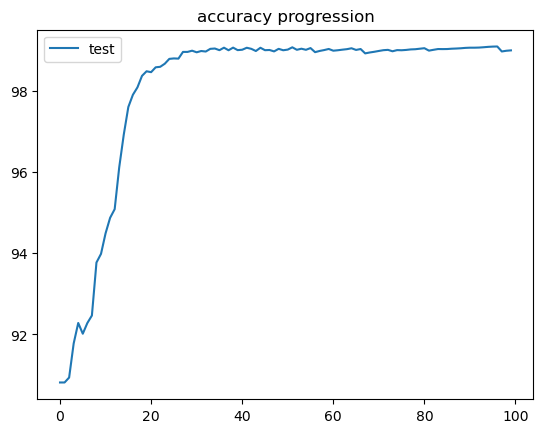

In [27]:
print(save_dir)
DATA_ROOT = osj("/mimer/NOBACKUP/groups/snic2022-22-122/arthur/", "dataset_beats")
DICT_BEATS = osj(DATA_ROOT, "5min_normal_beats.pkl")
DATA_BEATS = osj(DATA_ROOT, "30min_beats.pkl")

DATA_ROOT = "/mimer/NOBACKUP/groups/snic2022-22-122/arthur/physionet.org/files/mitdb/1.0.0/"
RECORDS = osj(DATA_ROOT, "RECORDS")
#print(RECORDS)
patient_ids = pd.read_csv(RECORDS, header=None).to_numpy().reshape(-1)
#print(patient_ids)
paced_patients = get_paced_patients(patient_ids)
excluded_patients = np.array([105, 114, 201, 202, 207, 209, 213, 222, 223, 234])  # according to paper
#print(np.concatenate((paced_patients, excluded_patients)))

dict_beats = read_dict_beats()
data_beats = read_data_beats()
ensure_normalized_and_detrended(dict_beats)
ensure_normalized_and_detrended(data_beats)

import collections

patients_out = np.concatenate((paced_patients, excluded_patients))
patients_left = list(copy.deepcopy(patient_ids))

for idx, i in enumerate(patient_ids):
    if i in patients_out:
        patients_left.remove(i)

labels = ['N', 'V', 'S', 'Q', 'F']
dictionary = {}
for i in labels:
    dictionary[i] = 0

list1 = []
array = np.zeros((len(patients_left), 2))
for idx, i in enumerate(patients_left):
    list1.append(data_beats[i]['class'])
    counter = collections.Counter(data_beats[i]['class'])
    for j in counter.keys():
        dictionary[j] += counter[j]
        if j == 'N':
            array[idx, 0] += counter[j]
        else:
            array[idx, 1] += counter[j]

seconds = 5
data_beats_train, data_beats_val, data_beats_test = train_test_split(data_beats, seconds)

import collections
from time import time
import random
from sklearn.metrics import f1_score, confusion_matrix
import pandas

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
experiment_name = settings['experiment_name']
test = 'bandits'
print('type: ',test)
n_epochs = 100 #settings['n_epochs']
patients_example = [119, 215, 232]
p2p2 = P2P_AFPL(patients_left, data_beats_train, data_beats_val,data_beats_test,settings['n_clients_UCB'], test)
alphas = p2p2.loop(n_epochs, p2p2, experiment_name)

[99.89429175475686, 99.6778350515464, 99.88472622478386, 99.7628927089508, 98.7048398091343, 99.90512333965845, 99.94343891402715, 99.90539262062441, 99.79919678714859, 100.0, 99.45219123505976, 99.92169146436962, 99.10337552742617, 99.93954050785973, 99.87096774193547, 100.0, 99.7624703087886, 98.36674090571641, 99.03002309468822, 96.57396211205159, 96.6078697421981, 97.72357723577237, 96.23753399818676, 100.0, 99.57514604354753, 99.89285714285714, 93.80925822643614, 98.18181818181819, 99.20792079207921, 99.70743124634289, 99.94675186368477, 99.92348890589136, 98.37947332883186, 99.45397815912636]
[100, 101, 103, 106, 108, 109, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 203, 205, 208, 210, 212, 214, 215, 219, 220, 221, 228, 230, 231, 232, 233]
118
99.10337552742617
124
98.36674090571641
220
98.18181818181819


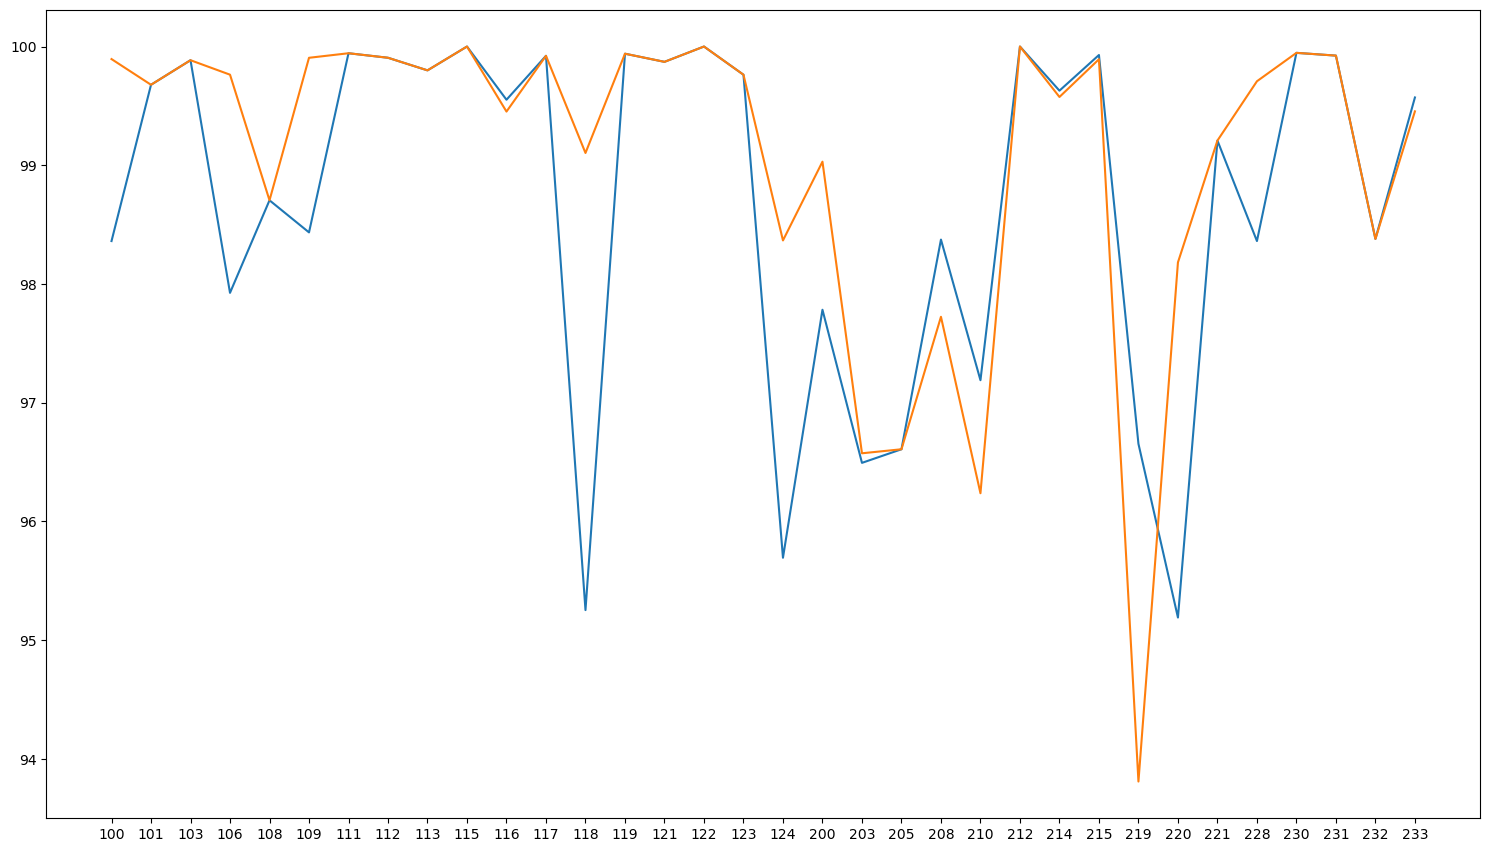

In [35]:
best_accuracies_bandit = p2p2.accuracy_list
print(best_accuracies_bandit)
fig = plt.gcf()
plt.plot(best_accuracies_local)
plt.plot(best_accuracies_bandit)
plt.xticks(ticks = [x for x in range(34)],labels=patients_left)
fig.set_size_inches(18.5,10.5)
print(patients_left)
print(patients_left[12])
print(best_accuracies_bandit[12])
print(patients_left[17])
print(best_accuracies_bandit[17])
print(patients_left[27])
print(best_accuracies_bandit[27])
